In [2]:
cd ~/code/jwstmc/

/home/lnie/code/jwstmc


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import os
import time
import webbpsf
nrca_short_filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M', 'F187N',
                          'F200W', 'F210M', 'F212N']
nrca_long_filters = ['F250M', 'F277W', 'F300M', 'F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F405N', 'F410M',
                         'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

nrca_short_detectors = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']
nrca_long_detectors = ['NRCA5', 'NRCB5']
F090W_fname="jw02736001001_02101_"
F150W_fname="jw02736001001_02103_"
F200W_fname="jw02736001001_02105_"
F277W_fname="jw02736001001_02101_"
F356W_fname="jw02736001001_02103_"
F444W_fname="jw02736001001_02105_"
sdetect=["nrca1","nrca2","nrca3","nrca4","nrcb1","nrcb2","nrcb3","nrcb4"]
ldetect=["nrcalong","nrcblong"]
detector=dict({"nrca1":"nrca1","nrca2":"nrca2","nrca3":"nrca3","nrca4":"nrca4",
               "nrcb1":"nrcb1","nrcb2":"nrcb2","nrcb3":"nrcb3","nrcb4":"nrcb4",
               "nrcalong":"nrca5","nrcblong":"nrcb5"})
filte_name=dict({"F090W":"jw02736001001_02101_","F150W":"jw02736001001_02103_",
                "F200W":"jw02736001001_02105_","F277W":"jw02736001001_02101_",
                "F356W":"jw02736001001_02103_","F444W":"jw02736001001_02105_"})
f2detpath=dict({"F090W":sdetect,"F150W":sdetect,"F200W":sdetect,
                "F277W":ldetect,"F356W":ldetect,"F444W":ldetect})
gains=dict({"nrca1":"2.08","nrca2":"2.02","nrca3":"2.17","nrca4":"2.02",
            "nrcb1":"2.01","nrcb2":"2.14","nrcb3":"1.94","nrcb4":"2.03",
            "nrcalong":"1.84","nrcblong":"1.80"})

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [3]:
dirs="/data/JWST_rev/"
Cam="NIRCam/"
filtes=["F277W","F356W","F444W"]
cat_header=["#   1 NUMBER                 Running object number\n",                                  
"#   2 X_IMAGE                Object position along x                                      [pixel]\n",
"#   3 Y_IMAGE                Object position along y                                      [pixel]\n",
"#   4 FWHM_IMAGE             FWHM assuming a gaussian core                                [pixel]\n",
"#   5 FLUX_RADIUS            Fraction-of-light radii                                      [pixel]\n",
"#   6 FLUX_AUTO              Flux within a Kron-like elliptical aperture                  [count]\n",
"#   7 FLUXERR_AUTO           RMS error for AUTO flux                                      [count]\n",
"#   8 FLAGS                  Extraction flags                                                    \n"                                          
"#   9 CLASS_STAR             S/G classifier output\n"]

#defination useful functions
def get_filename(file_dir,append):
    fname=[];
    for list in os.listdir(file_dir):
        if os.path.isfile(os.path.join(file_dir,list)):
            if list[(len(list)-len(append)):len(list)]==append:
                fname.append(list);

    return fname
def write_fits(fitsname,data,head1=None,head2=None):
    wdata=data;
    if head1==None :
        #print("head1 none",fitsname)
        hdu = fits.PrimaryHDU(wdata)
        hdul = fits.HDUList([hdu])
        hdul.writeto(fitsname,overwrite=True)
    if head1!=None and head1==None:
        #print("head2 none",fitsname)
        hdu = fits.PrimaryHDU(wdata,header=head1)
        hdul = fits.HDUList([hdu])
        hdul.writeto(fitsname,overwrite=True)
    if head1!=None and head2!=None:
        #print("head1 not none",fitsname)
        hdu = fits.PrimaryHDU(header=head1)
        hdu1= fits.ImageHDU(wdata,header=head2)
        hdul = fits.HDUList([hdu,hdu1])
        hdul.writeto(fitsname,overwrite=True)
def fft_conv(image,psf):
    '''
    convlove image with a psf,usually image size should be larger than psf
    '''
    size=image.shape
    core=np.zeros(size,dtype='float')
    nx=image.shape[0];ny=image.shape[1]
    px=psf.shape[0];py=psf.shape[1]
    ra=int((nx-px)/2);rb=int((ny-py)/2)
    core[ra-1:ra+px-1,rb-1:rb+py-1]=psf
    Fg=np.fft.fft2(image)
    Fp=np.fft.fft2(core)
    Fg*=Fp
    for i in range(Fp.real.shape[0]):
        for j in range(Fp.real.shape[1]):
            l=(i+j+2)%2
            if (l==1) :Fg.real[i][j]*=-1;Fg.imag[i][j]*=-1;
    tmp=np.fft.ifft2(Fg)
    cimage=tmp.real
    return(cimage)

def pixel2wcs(header,px,py):
    CD1_1   =  header['CD1_1']
    CD1_2   =  header['CD1_2']
    CD2_1   =  header['CD2_1']
    CD2_2   =  header['CD2_2'] 
    CRPIX1  =  header['CRPIX1']
    CRPIX2  =  header['CRPIX2']  
    CRVAL1  =  header['CRVAL1']
    CRVAL2  =  header['CRVAL2'] 
    MCD=np.array([[CD1_1,CD1_2],
                  [CD2_1,CD2_2]])
    Mp=np.array([px-CRPIX1,py-CRPIX2])
    Mt=np.matmul(MCD,Mp)
    Mwcs=np.array([CRVAL1,CRVAL2])
    Mwcs=Mt+Mwcs
    return(Mwcs[0],Mwcs[1])

def wcs2pixel(header,wcsx,wcsy):
    CD1_1   =  header['CD1_1']
    CD1_2   =  header['CD1_2']
    CD2_1   =  header['CD2_1']
    CD2_2   =  header['CD2_2'] 
    CRPIX1  =  header['CRPIX1']
    CRPIX2  =  header['CRPIX2']  
    CRVAL1  =  header['CRVAL1']
    CRVAL2  =  header['CRVAL2'] 
    MCD=np.array([[CD1_1,CD1_2],
                  [CD2_1,CD2_2]])
    Mp=np.array([wcsx-CRVAL1,wcsy-CRVAL2])
    iMCD=np.linalg.inv(MCD)
    Mt=np.matmul(iMCD,Mp)
    Mpos=np.array([CRPIX1,CRPIX2])
    Mpos=Mt+Mpos
    return(Mpos[0],Mpos[1])


In [9]:
#for F356W parallel field 
fn="/data/JWST_rev/coadd_img/rev4/parallel_field/F356Wblong_it1_UPDC_rev4.fits"
fn="/data/JWST_rev/coadd_img/rev4/cluster_field/F356Wblong_it1_UPDC_rev4.fits"
catname="/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star/F356Wblong_it0_UPDC_rev4_star.cat"
stampname="/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Wblong_it0_UPDC_rev4_star.fits"
maskname="/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Wblong_it0_UPDC_rev4_mask.fits"
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import ctypes
import webbpsf
import os
from scipy.stats import sigmaclip
from astropy.stats import SigmaClip
from astropy.wcs import WCS

from psf_fit import star_shape,write_fits,get_filename,\
web_psf_fit,web_psf_rec,int2cent,model2pos,wgtmap,gaus_estimate\
,write_mult_fits,polyfit2d
from C_tools_lib import centriod_psf
from mcmcs import coeff2psf,interp_cubic

def size(image,center,sigma):
    '''
    size(image,center,sigma)
    center[0]=cx;center[1]=cy
    '''
    nx=image.shape[0];ny=image.shape[1]
    #print("nx=%d,ny=%d"%(nx,ny))
    W=0;R11=0;R22=0;R12=0;R2=0.;k=0;
    nh=(np.min([nx,ny])*0.5)**2
    #print("nh=%d,cx=%f,cy=%f"%(nh,center[0],center[1]))
    scale=0.5/(sigma**2)
    for i in range(nx):
        for j in range(ny):
            x=i-center[0];y=j-center[1]
            r2=x**2+y**2;weight=np.exp(-r2*scale)
            if r2<nh:
                W=W+image[i][j]*weight
                R11=R11+x*x*image[i][j]*weight
                R22=R22+y*y*image[i][j]*weight
                R12=R12+x*y*image[i][j]*weight
                #if k<10 :print(image[i][j],weight,sigma)
                #k=k+1;
    R11=R11/W;R22=R22/W;R12=R12/W
    #print("message:w11=%f,w12=%f,w22=%f,w=%f"%(R11,R12,R22,W))
    e1=(R11-R22)/(R11+R22)
    e2=(2.*R12)/(R11+R22)
    #print("message")
    R2=R11+R22
    #print(e1,e2,R2)
    if R2<=0 : R2=0.001
    if R2<=0 or np.fabs(e1)>=1. or np.fabs(e2)>=1.:
        #raise Exception("R2<=0\n")
        print("R2<=0\n");
        return(e1,e2,R2)
    else:
        return(e1,e2,R2)
    
def S2N(image,gain=1):
    Ng1=image.shape[0]
    Ng2=image.shape[1]
    weight=np.zeros(image.shape,dtype='float')
    mean,sigma=gaus_estimate(image)
    #print("method=%f,sigma=%f"%(mean,sigma))
    for i in range(Ng1):
        for j in range(Ng2):
            detx=sigma*sigma*gain*gain
            dety=gain*np.fabs(image[i][j])
            if dety<detx : error=sigma
            else : error=np.sqrt(dety+detx)/gain
            #weight[i][j]=1./(error**2)
            weight[i][j]=error
    snr=np.sum(image)/np.sqrt(np.sum(weight**2))
    return(snr)

nrca_short_detectors = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']
nrca_long_detectors = ['NRCA5', 'NRCB5']
F090W_fname="jw02736001001_02101_"
F150W_fname="jw02736001001_02103_"
F200W_fname="jw02736001001_02105_"
F277W_fname="jw02736001001_02101_"
F356W_fname="jw02736001001_02103_"
F444W_fname="jw02736001001_02105_"
sdetect=["nrca1","nrca2","nrca3","nrca4","nrcb1","nrcb2","nrcb3","nrcb4"]
ldetect=["nrcalong","nrcblong"]
ldetect=["nrcblong"]
detector=dict({"nrca1":"nrca1","nrca2":"nrca2","nrca3":"nrca3","nrca4":"nrca4",
               "nrcb1":"nrcb1","nrcb2":"nrcb2","nrcb3":"nrcb3","nrcb4":"nrcb4",
               "nrcalong":"nrca5","nrcblong":"nrcb5"})
filte_name=dict({"F090W":"jw02736001001_02101_","F150W":"jw02736001001_02103_",
                "F200W":"jw02736001001_02105_","F277W":"jw02736001001_02101_",
                "F356W":"jw02736001001_02103_","F444W":"jw02736001001_02105_"})
f2detpath=dict({"F090W":sdetect,"F150W":sdetect,"F200W":sdetect,
                "F277W":ldetect,"F356W":ldetect,"F444W":ldetect})
gains=dict({"nrca1":"2.08","nrca2":"2.02","nrca3":"2.17","nrca4":"2.02",
            "nrcb1":"2.01","nrcb2":"2.14","nrcb3":"1.94","nrcb4":"2.03",
            "nrcalong":"1.84","nrcblong":"1.80"})




osam=2
npc=10

Cam="NIRCam/"
filte="F356W"
odirs="/data/SMACS0723_NIRCam_pipeline1.8.1/"+filte+'/'
dirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'
PCdirs="/home/lnie/data/PC/JWST/"+Cam+filte+'/'
stamp_dirs=dirs+"/catalogue/star_stamps/"
TNg=80
ikk=0
Nim=5
cent=np.zeros(2,dtype='float')
hdu0=fits.open(fn)
cat=np.loadtxt(catname)
readstar=fits.open(stampname)[0].data
mask=fits.open(maskname)[0].data
Nobj=readstar.shape[0];Ng0=readstar.shape[1]
shapes=np.zeros((Nobj,2),dtype='float')
XPOSURE=hdu0['SCI'].header['XPOSURE']
PHOTMJSR=hdu0['SCI'].header['PHOTMJSR']
readstar*=(PHOTMJSR*XPOSURE)
#clear the candidates
for ic in range(Nobj):
    rx=cat[ic][1]+0.5;ry=cat[ic][2]+0.5
    cent[0],cent[1],sigma=centriod_psf(readstar[ic])
    oe1,oe2,or2=size(readstar[ic],cent,3.);
    mage=(oe1**2+oe2**2)**0.5
    shapes[ic][0]=mage;shapes[ic][1]=or2
cleane,low,high=sigmaclip(shapes[:,0],3.,3.)
cleanr,low,high=sigmaclip(shapes[:,1],3.,3.)
print("clean Nobj=",cleane.shape[0])
spos=np.zeros((cleane.shape[0],2),dtype='float')
instar=np.zeros((cleane.shape[0],Ng0,Ng0),dtype='float')
wgt=np.zeros(instar.shape,dtype='float');print(instar.shape,wgt.shape)
k=0
for ic in range(Nobj):
    if k <cleane.shape[0] and shapes[ic][0]==cleane[k]:
        spos[k][0]=cat[ic][1];spos[k][1]=cat[ic][2]
        instar[k]=readstar[ic].T
        wgt[k]=mask[ic].T
        k+=1
Nobj=k;print("clean Nobj=",Nobj)


tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
print(stamp_dirs+slicename+"_comodel.fits")
try:
    hdu=fits.open(stamp_dirs+slicename+"_comodel3.fits")
    comodel=hdu[0].data
except:
    wmodel=np.zeros((9,Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    comodel=np.zeros((Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    for det in f2detpath[filte]:
        gain=float(gains[det])
        stamp_dirs=dirs+det+'/'+"catalogue/star_stamps/"
        for Tim in range(9):
            expos=Tim+1
            indx=str(int(expos/10000))+str(int(expos/1000)%10)+str(int(expos/100)%10)+str(int(expos/10)%10)+str(expos%10)
            ofname=(odirs+filte_name[filte]+indx+'_'+det+"_cal.fits");print(ofname)
            stamp_name=(stamp_dirs+filte_name[filte]+indx+'_'+det+"_cal_pv181_rev4_star.fits")
            tmpname=stamp_name.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len("_star.fits")]
            hdu=fits.open(ofname);OPD=hdu[0].header['DATE-BEG'];
            print("OPD:",OPD)
            PHOTUJA2=hdu['SCI'].header['PHOTUJA2'];XPOSURE=hdu['SCI'].header['XPOSURE']
            PHOTMJSR=hdu['SCI'].header['PHOTMJSR']
            PIXAR_A2=hdu['SCI'].header['PIXAR_A2']
            nrc = webbpsf.NIRCam()
            nrc.filter =filte
            if "blong" in fn : nrc.detector="NRCA5"
            if "along" in fn : nrc.detector="NRCB5"
            nrc.load_wss_opd_by_date(OPD)
            print(filte,detector[det].upper(),OPD)
            for ic in range(Nobj):
                '''w = WCS(hdu0['SCI'].header)
                wcsx,wcsy=w.wcs_pix2world(spos[ic][0],spos[ic][1],1)
                w = WCS(hdu['SCI'].header)
                ipx,ipy=w.wcs_world2pix(wcsx,wcsy,1)
                print(spos[ic][0],spos[ic][1],ipx,ipy)'''
                w = WCS(hdu0['SCI'].header)
                wcsx,wcsy=w.wcs_pix2world(spos[ic][0],spos[ic][1],1)
                w = WCS(hdu['SCI'].header)
                ipx,ipy=w.wcs_world2pix(wcsx,wcsy,1)
                print(spos[ic][0],spos[ic][1],ipx,ipy)
                if(ipx>0 and ipx<2047 and ipy>0 and ipy<2047):
                    nrc.detector_position=(ipx,ipy)
                    psf = nrc.calc_psf(fov_pixels=Ng0+Nim,oversample=2)
                    wmodel[Tim][ic]=(psf[2].data/np.sum((psf[2].data))).T              
    for ic in range(Nobj):
        for ex in range(9):
            if wmodel[ex][ic].any!=0:
                comodel[ic,:,:]+=wmodel[ex,ic,:,:]
        comodel[ic]/=np.sum(comodel[ic])
    stamp_dirs=dirs+"/catalogue/star_stamps/"
    tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
    write_fits(stamp_dirs+slicename+"_comodel.fits",comodel)


tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")]  
PCs,pos,coeff,getNobj,slecstar,webcoeff,slecwgt,slecimodel=web_psf_fit(
    instar,
    spos,
    npc,
    gain=1.84,
    method=1,
    wgt=wgt,
    imodel=comodel,
    osam=2,
    SNRs=5)
wgt=slecwgt;comodel=slecimodel
polyorder=2
if getNobj>10:polyorder=3
if getNobj>15:polyorder=4
if getNobj>21:polyorder=5
rPSF=coeff2psf(pos,coeff,PCs,pos,degrees=polyorder);print("rPSF",rPSF.shape)
icoeff=polyfit2d(pos,webcoeff[:,0],webcoeff[:,1],pos,polyorder)
eNg=rPSF.shape[1]
Ng=int(eNg/osam)
sNg=30;dpix=int((slecstar.shape[1]-sNg)/2);cut=int(((Ng0+Nim)*osam-eNg)/2)
mix_mod=np.zeros(rPSF.shape,dtype='float')
rrPSF=np.zeros((getNobj,sNg,sNg),dtype='float')
chi1=np.zeros((getNobj,sNg,sNg))
chi2=np.zeros((getNobj,sNg,sNg))
residu1=np.zeros((getNobj,sNg,sNg))
residu2=np.zeros((getNobj,sNg,sNg))
fp=open(stamp_dirs+slicename+"_3mcoshape.cat","w")
fpw=open(stamp_dirs+slicename+"_3mcwshape.cat","w")
fpm=open(stamp_dirs+slicename+"_3mcmshape.cat","w")
for ic in range(getNobj):
    mean,sigma=gaus_estimate(slecstar[ic]);
    print(ic,mean,sigma)
    #mean,sigma=gaus_estimate(rPSF[ic]);rPSF[ic]-=mean
    slecstar[ic]-=mean
    #slecstar[ic]*=wgt[ic]
    snrs=S2N(slecstar[ic],gain=1.84)
    slecstar[ic]/=np.sum(slecstar[ic])
    tmp=wgtmap(slecstar[ic])
    tmp_img=slecstar[ic][dpix:dpix+sNg,dpix:dpix+sNg]
    tmp_wgt=wgt[ic][dpix:dpix+sNg,dpix:dpix+sNg]#mask
    tmp_img*=tmp_wgt
    #tmp_img/=np.sum(tmp_img) #normalise
    error_map=tmp[dpix:dpix+sNg,dpix:dpix+sNg];#error_map/=sums  #weight map
    tmp_wmap=1./(error_map*error_map)*tmp_wgt;
    cent[0],cent[1],sigma=centriod_psf(tmp_img);
    print(cent[0],cent[1])
    dx=cent[0]-(sNg/2.+0.5)+1;dy=cent[1]-(sNg/2.+0.5)+1
    rrPSF[ic]=interp_cubic(rPSF[ic],sNg,dy,dx,osam=2)
    tmp_mod=interp_cubic(comodel[ic],sNg,dy,dx,osam=2)
    #print("sum:", np.sum(rrPSF[ic]))
    #mean,sigma=gaus_estimate(rrPSF[ic]);rrPSF[ic]-=mean
    rrPSF[ic]=rrPSF[ic].T;
    tmp_mod*=tmp_wgt;
    frac=(1.-np.sum(comodel[ic,cut:cut+eNg,cut:cut+eNg]))
    #rPSF=rPSF/np.sum(rPSF)*frac
    #tmp_mod/=np.sum(tmp_mod)
    for i in range(eNg):
        for j in range(eNg):
            mix_mod[ic][i][j]=0
            mix_mod[ic][i][j]=(rPSF[ic][i][j]+comodel[ic][i+cut][j+cut]*icoeff[ic])#mixture model
            if mix_mod[ic][i][j]<0 : mix_mod[ic][i][j]=0
    for i in range(eNg):
        for j in range(eNg):
            if mix_mod[ic][i][j]==0 and i-1>0 and i+1<eNg and j-1>0 and j+1<eNg:
                mix_mod[ic][i][j]=(mix_mod[ic][i-1][j-1]+mix_mod[ic][i-1][j]+mix_mod[ic][i-1][j+1]+
                                   mix_mod[ic][i][j-1]+mix_mod[ic][i][j+1]+
                                   mix_mod[ic][i+1][j-1]+mix_mod[ic][i+1][j]+mix_mod[ic][i+1][j+1])/8.
    tmp_mix_mod=interp_cubic(mix_mod[ic],sNg,dy,dx,osam)
    tmp_mix_mod*=tmp_wgt;
    print(np.sum(tmp_img),np.sum(tmp_mix_mod))
    #mean,sigma=gaus_estimate(tmp_mix_mod);tmp_mix_mod-=mean
    tmp_img/=np.sum(tmp_img);tmp_mod/=np.sum(tmp_mod);tmp_mix_mod/=np.sum(tmp_mix_mod)
    residu1[ic]=(tmp_img-tmp_mod).T
    residu2[ic]=(tmp_img-tmp_mix_mod).T
    oe1,oe2,or2=size(tmp_img,cent,3.);
    we1,we2,wr2=size(tmp_mod,cent,3.);
    me1,me2,mr2=size(tmp_mix_mod,cent,3.);
    print(oe1,oe2,or2)
    print(me1,me2,mr2)
    fpw.writelines(str(we1)+'\t'+str(we2)+'\t'+str(wr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fp.writelines(str(oe1)+'\t'+str(oe2)+'\t'+str(or2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fpm.writelines(str(me1)+'\t'+str(me2)+'\t'+str(mr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    chi1[ic]=residu1[ic]*residu1[ic]*tmp_wmap
    chi2[ic]=residu2[ic]*residu2[ic]*tmp_wmap
#write_fits("fits/rPSF.fits",rrPSF)
fp.close();fpw.close();fpm.close()
write_fits(stamp_dirs+slicename+"_webchi.fits",chi1)
write_fits(stamp_dirs+slicename+"_mixchi.fits",chi2)
write_fits(stamp_dirs+slicename+"_webresidu.fits",residu1)
write_fits(stamp_dirs+slicename+"_mixresidu.fits",residu2)  
#write_fits("fits/ostars.fits",instar)
oshape=np.loadtxt(stamp_dirs+slicename+"_3mcoshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_3mcmshape.cat")
de1=oshape[:,0]-wshape[:,0];de2=oshape[:,1]-wshape[:,1];dr=(oshape[:,2]**0.5-wshape[:,2]**0.5)
print(np.mean(oshape[:,0]),np.mean(oshape[:,1]),np.mean(oshape[:,2]))
print(np.mean(de1),np.std(de1),np.mean(de2),np.std(de2),np.median(dr),np.std(dr),
      np.mean((oshape[:,2]-wshape[:,2])/oshape[:,2]))

        



clean Nobj= 41
(41, 80, 80) (41, 80, 80)
clean Nobj= 41
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Wblong_it1_UPDC_rev4_comodel.fits
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00001_nrcblong_cal.fits
OPD: 2022-06-07T02:56:26.340

MAST OPD query around UTC: 2022-06-07T02:56:26.340
                        MJD: 59737.12252708333

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2095 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9356 days
User requested choosing OPD time closest in time to 2022-06-07T02:56:26.340, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.936 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field p

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160729e+03 1555.01 1879.0160765788503 619.0712104309282


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479551e+03 1751.516 1545.900915568089 713.3376654497379


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.514939e+03 914.7977 588.4080056031378 300.95873341322863


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.079839e+02 4457.371 88.4304870629885 2025.8526913989945


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.901581e+03 3226.628 1260.2205677293118 1431.217357977056


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.25973e+03 827.0685 1440.6951383305095 262.12966772568006


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381896e+02 2065.102 157.57008856797256 859.80433527277


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399455e+03 3720.974 1502.2141708930233 1673.359198326552


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.849503e+03 1694.281 749.985969336949 681.749234211055


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068379e+03 452.3908 371.3998978244888 74.50465470833547


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565547e+03 1400.189 1100.3547389464584 539.9838498938984


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.829304e+02 3207.304 30.26099761905914 1416.104177555649


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248846e+03 3068.7 941.8184410116427 1352.745001375958


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024322e+03 4548.731 828.7350330794613 2073.821678906606
440.3543 591.8305 64.37505417450245 141.06874919155848


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404121e+03 778.7627 1999.6803254107683 241.16451841954233


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529013e+03 1370.133 594.2243136254289 522.9877138514001


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504432e+03 3914.301 2041.390357442072 1770.1122258881846


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388865e+03 2190.647 1988.9528940392897 929.4894230896327


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483834e+03 568.9273 1550.7373857542389 136.78025154109696


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.271189e+03 934.0386 469.3259630253607 309.7887245161735


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.515296e+03 1817.055 1563.2051716436 745.3717608450224


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410186e+03 1531.439 1512.5367350843346 605.883117557519


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.96703e+03 3293.382 803.6697079211635 1461.651076930208


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989186e+03 764.4165 1797.0765910135465 233.23237683560853


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.35261e+03 1387.413 1484.7532958111124 535.533617326519


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107425e+03 2166.795 1851.56464037998 917.2244430426515


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207339e+03 3719.084 1896.7555726314308 1674.2634502277178


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455149e+03 1936.2 1533.5553333646099 803.3245751924998


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.287079e+02 3242.903 199.0417515457575 1434.2417619526318


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.499049e+02 1606.86 -30.988448334942177 635.5125343060375
289.0505 1908.685 -12.571908464606622 782.7547494404839
2015.476 3019.131 827.9652700242193 1328.0504177133803


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347917e+03 913.5637 1971.9197465583613 306.759272894403


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020633e+03 3585.568 340.81051712348017 1601.966629351381


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.566498e+03 4411.365 2070.547112407914 2012.5943469758338
3740.988 3426.967 1669.6871138577435 1530.7889080646924


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236112e+03 749.0096 1429.3422648651822 224.01894318559812


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010797e+03 450.3241 343.28403569203954 73.36691411358265


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.443' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.545' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166886e+03 1193.054 1882.863012701742 442.6147095364936
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00002_nrcblong_cal.fits
OPD: 2022-06-07T03:12:11.171

MAST OPD query around UTC: 2022-06-07T03:12:11.171
                        MJD: 59737.13346262732

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2205 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9247 days
User requested choosing OPD time closest in time to 2022-06-07T03:12:11.171, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.925 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCB5 2022-06-07T03:12:11.171
4.39271e+02 829.3475 60.32426462485387 351.8918317177893

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160729e+03 1555.01 1876.0461170779054 714.0936215975312


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479551e+03 1751.516 1542.9310877070136 808.3605370300562


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.514939e+03 914.7977 585.4376010174984 395.9829325326625


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.079839e+02 4457.371 85.46247739679359 2120.877590374984
2901.581 3226.628 1257.2517432669176 1526.2406268130665


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.25973e+03 827.0685 1437.7246784169524 357.15268829276


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381896e+02 2065.102 154.60046046824777 954.8291272340132


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399455e+03 3720.974 1499.2456877433353 1768.3821350744802


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.849503e+03 1694.281 747.0160954658702 776.7732070071783


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068379e+03 452.3908 368.4291784828283 169.52915689521683


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565547e+03 1400.189 1097.384667806616 635.0073387367822


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.829304e+02 3207.304 27.29214094559086 1511.1291480537243


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248846e+03 3068.7 938.8495041829422 1447.7687100857286


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024322e+03 4548.731 825.7671010794894 2168.8455544373855
440.3543 591.8305 61.40442805935777 236.09367514221526


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404121e+03 778.7627 1996.7098350066944 336.1867659829488


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529013e+03 1370.133 591.2542182613211 618.0119029835341


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504432e+03 3914.301 2038.4220160577097 1865.1344179559244


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388865e+03 2190.647 1985.9833708569736 1024.5116813404372


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483834e+03 568.9273 1547.7667500068392 231.80312148613473


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.271189e+03 934.0386 466.3555708325973 404.8130882734803


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.515296e+03 1817.055 1560.2353887143504 840.3946083779282


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410186e+03 1531.439 1509.5667566147602 700.9060357867138


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.96703e+03 3293.382 800.7009218233545 1556.6749777534023


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989186e+03 764.4165 1794.1060899080728 328.25490475916206


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.35261e+03 1387.413 1481.7832187688414 630.5565744247318


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107425e+03 2166.795 1848.5950994295551 1012.2468913690623


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207339e+03 3719.084 1893.7870949882335 1769.285841064767


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455149e+03 1936.2 1530.5856315561327 898.3474635971206


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.287079e+02 3242.903 196.07292163515422 1529.2664990926762


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.499049e+02 1606.86 -33.958388385847684 730.5375877178394
289.0505 1908.685 -15.54164419965764 877.7797768888977
2015.476 3019.131 824.9962978050553 1423.0742837598607


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347917e+03 913.5637 1968.9493483758054 401.78155809959264


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020633e+03 3585.568 337.8419217570704 1696.9911721838412


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.566498e+03 4411.365 2067.579112256529 2107.616502872461
3740.988 3426.967 1666.7184325899552 1625.8116113482556


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236112e+03 749.0096 1426.3717516101656 319.0419799128168


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010797e+03 450.3241 340.3133148469177 168.3914552087915


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:15.274' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:19.376' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166886e+03 1193.054 1879.8928054267649 537.6371166107654
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00003_nrcblong_cal.fits
OPD: 2022-06-07T03:27:34.562

MAST OPD query around UTC: 2022-06-07T03:27:34.562
                        MJD: 59737.144150023145

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2311 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9140 days
User requested choosing OPD time closest in time to 2022-06-07T03:27:34.562, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.914 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCB5 2022-06-07T03:27:34.562
4.39271e+02 829.3475 155.79487234197154 354.7245265837

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160729e+03 1555.01 1971.516632416077 716.9267613286622


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479551e+03 1751.516 1638.4015751582358 811.1935950929033


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.514939e+03 914.7977 680.9081912493715 398.8157550630981


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.079839e+02 4457.371 180.93263897293696 2123.7102781024287
2901.581 3226.628 1352.7220480495507 1529.0736162318249


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.25973e+03 827.0685 1533.1952784747868 359.9857184575893


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381896e+02 2065.102 250.07091476981395 957.661840703053


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399455e+03 3720.974 1594.7159332745978 1771.2151871927665


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.849503e+03 1694.281 842.4865888418235 779.6060681713641


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068379e+03 452.3908 463.89982779705656 172.36192776482108


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565547e+03 1400.189 1192.8551963689752 637.8402863373246


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.829304e+02 3207.304 122.76245711994989 1513.9618253976184


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248846e+03 3068.7 1034.319828109868 1450.601618669276


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024322e+03 4548.731 921.2372436862431 2171.678433953216
440.3543 591.8305 156.87506493640024 238.92637122337305


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404121e+03 778.7627 2092.18044736142 339.0199320508249
1529.013 1370.133 686.7247525364601 620.8447261722123


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504432e+03 3914.301 2133.8922447435107 1867.9676090686678
4388.865 2190.647 2081.4538099524793 1027.3448510253088
3483.834 568.9273 1643.237382543175 234.63617782117865


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.271189e+03 934.0386 561.8261598560953 407.64588172850733


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.515296e+03 1817.055 1655.7058682744064 843.2276708949814


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410186e+03 1531.439 1605.0372707870351 703.7390850710183


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.96703e+03 3293.382 896.1712186287286 1559.5078512585242


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989186e+03 764.4165 1889.576701071787 331.0880214824157


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.35261e+03 1387.413 1577.2537503962562 633.3896165392711


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107425e+03 2166.795 1944.0655393704042 1015.08002669406


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207339e+03 3719.084 1989.257345261043 1772.1189941827542


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455149e+03 1936.2 1626.0560962519187 901.180519064719


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.287079e+02 3242.903 291.5432306112434 1532.0992191392234


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.499049e+02 1606.86 61.51212557616486 733.3702562482157


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.890505e+02 1908.685 79.92883232350937 880.6124486940085


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015476e+03 3019.131 920.4666281697561 1425.9071635445484


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347917e+03 913.5637 2064.419943757008 404.6147179865908
1020.633 3585.568 433.3121866663977 1699.8239273723484


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.566498e+03 4411.365 2163.0492805309527 2110.4497040184015
3740.988 3426.967 1762.1887157525953 1628.644705367646


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236112e+03 749.0096 1521.8423611703765 321.8750071663686


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010797e+03 450.3241 435.7839647749745 171.22421928653034


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.665' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:42.767' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166886e+03 1193.054 1975.3633651964603 540.4702558662844
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00004_nrcblong_cal.fits
OPD: 2022-06-07T03:42:57.954

MAST OPD query around UTC: 2022-06-07T03:42:57.954
                        MJD: 59737.15483743056

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2418 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9033 days
User requested choosing OPD time closest in time to 2022-06-07T03:42:57.954, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.903 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCB5 2022-06-07T03:42:57.954
4.39271e+02 829.3475 158.76173777981592 259.69982397773

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160729e+03 1555.01 1974.482113457863 621.908963382072


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479551e+03 1751.516 1641.3666936657216 716.1745328477359


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.514939e+03 914.7977 683.874889796055 303.79304833764854


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.079839e+02 4457.371 183.89273332354765 2028.6856795291899


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.901581e+03 3226.628 1355.684411092034 1434.053473178421


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.25973e+03 827.0685 1536.1621294607962 264.966248916426


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381896e+02 2065.102 253.03547232372125 862.6375054457917


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399455e+03 3720.974 1597.6773649778752 1676.195963071498


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.849503e+03 1694.281 845.4518281903956 684.5839816206682


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068379e+03 452.3908 466.8673929271811 77.3383916343837


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565547e+03 1400.189 1195.8209798037208 542.8195288694886


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.829304e+02 3207.304 125.72488579664969 1418.9370091634416


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248846e+03 3068.7 1037.2824940600242 1355.5802658138855


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024322e+03 4548.731 924.1971454251725 2076.656647720831
440.3543 591.8305 159.84237359645147 143.90167021966113


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404121e+03 778.7627 2095.147381548996 244.00258573509655
1529.013 1370.133 689.6906002399664 525.8220455302178


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504432e+03 3914.301 2136.853300162029 1772.9504330779678
4388.865 2190.647 2084.41809772056 932.3274744385392
3483.834 568.9273 1646.2047154618465 139.61712359126125


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.271189e+03 934.0386 564.7928241382635 312.6227227673303


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.515296e+03 1817.055 1658.670863753487 748.2086747953589


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410186e+03 1531.439 1608.0028019454496 608.7198945856301


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.96703e+03 3293.382 899.1334677849204 1464.4859735464538


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989186e+03 764.4165 1892.5436647448141 236.06990527534094


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.35261e+03 1387.413 1580.219551668134 538.3703194164912


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107425e+03 2166.795 1947.0298744434251 920.062128011383


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207339e+03 3719.084 1992.2187703561353 1677.1012691261153


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455149e+03 1936.2 1629.02086914977 806.1614109978244


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.287079e+02 3242.903 294.5055887508797 1437.0750441767057


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.499049e+02 1606.86 64.47754171055942 638.3452019504633


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.890505e+02 1908.685 82.89368499471789 785.5874662053573


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015476e+03 3019.131 923.4293894339293 1330.8853780738975


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347917e+03 913.5637 2067.386625627591 309.59726756723
1020.633 3585.568 436.2739014949791 1604.8002907499204


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.566498e+03 4411.365 2166.009403264011 2015.432636867921
3740.988 3426.967 1765.1506938442267 1533.6261179862906


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236112e+03 749.0096 1524.8093584385292 226.8554936855786


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010797e+03 450.3241 438.7515341056866 76.20057631464613


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.057' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.159' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166886e+03 1193.054 1978.3295244920632 445.4524696804632
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00005_nrcblong_cal.fits
OPD: 2022-06-07T03:58:21.281

MAST OPD query around UTC: 2022-06-07T03:58:21.281
                        MJD: 59737.16552408565

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2525 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8926 days
User requested choosing OPD time closest in time to 2022-06-07T03:58:21.281, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.893 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCB5 2022-06-07T03:58:21.281
4.39271e+02 829.3475 161.72990788221387 164.67368599686

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160729e+03 1555.01 1977.449349769785 526.8875127810068


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479551e+03 1751.516 1644.3336828741321 621.152224713533


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.514939e+03 914.7977 686.8429485550885 208.76826500027505


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.079839e+02 4457.371 186.85631286551654 1933.6596146551328


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.901581e+03 3226.628 1358.6495290487642 1339.0304329955834


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.25973e+03 827.0685 1539.1302947456916 169.94366201289688


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381896e+02 2065.102 256.0020779442947 767.6116196129746


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399455e+03 3720.974 1600.6418506145412 1581.1735462835227


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.849503e+03 1694.281 848.4188974861789 589.5596211000947


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068379e+03 452.3908 469.83603864448276 -17.686956082875895
2565.547 1400.189 1198.7884192446463 447.79606960378874


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.829304e+02 3207.304 128.69004794957118 1323.910797741428


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248846e+03 3068.7 1040.247817471049 1260.5564046489287


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024322e+03 4548.731 927.1605931731698 1981.6324911716897


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403543e+02 591.8305 162.81084419089314 48.87553253806868


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404121e+03 778.7627 2098.115605467549 148.9814394696309
1529.013 1370.133 692.6580818440689 430.7972811452498


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504432e+03 3914.301 2139.817530003908 1677.9294060034495
4388.865 2190.647 2087.3845236317084 837.3063109106594
3483.834 568.9273 1649.1732084228663 44.59481764118061


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.271189e+03 934.0386 567.76085924375 217.5976326068485


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.515296e+03 1817.055 1661.6377694575897 653.1864116722497


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410186e+03 1531.439 1610.970071280115 513.6974989665609


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.96703e+03 3293.382 902.0985083259005 1369.4617562056096


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989186e+03 764.4165 1895.5119079093638 141.04823652469963


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.35261e+03 1387.413 1583.187004338121 443.34785109725976


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107425e+03 2166.795 1949.9963322266326 825.0406101583269


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207339e+03 3719.084 1995.1832514011398 1582.0798696188344


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455149e+03 1936.2 1631.9876236396244 711.1390721056287


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.287079e+02 3242.903 297.47070310848676 1342.0492679207694


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.499049e+02 1606.86 67.44472901596907 543.3188273600998


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.890505e+02 1908.685 85.8604903719463 690.5611409157952


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015476e+03 3019.131 926.3947774599569 1235.861223326763


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347917e+03 913.5637 2070.3546780194515 214.5760510880284
1020.633 3585.568 439.2385796042448 1509.7748796945862


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.566498e+03 4411.365 2168.9729993729015 1920.4116829978268
3740.988 3426.967 1768.115550516837 1438.604133451217


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236112e+03 749.0096 1527.7776230024783 131.83287671295307


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.384' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.486' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010797e+03 450.3241 441.72018255660464 -18.8248439115946
4166.886 1193.054 1981.2972215611735 350.43102616756846
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00006_nrcblong_cal.fits
OPD: 2022-06-07T04:13:44.672

MAST OPD query around UTC: 2022-06-07T04:13:44.672
                        MJD: 59737.176211481485

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2632 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8820 days
User requested choosing OPD time closest in time to 2022-06-07T04:13:44.672, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.882 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCB5 2022-06-07T04:13:44.67

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160729e+03 1555.01 1881.9842814478695 524.0468475599067


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479551e+03 1751.516 1548.8689080496736 618.3125815158076


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.514939e+03 914.7977 591.3768864136637 205.93155894247798


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.079839e+02 4457.371 91.3955918924363 1930.824457835612


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.901581e+03 3226.628 1263.1869806929565 1336.191666119036


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.25973e+03 827.0685 1443.664120060937 167.10434277519255


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381896e+02 2065.102 160.53774081125334 764.7762396721373


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399455e+03 3720.974 1505.1800540520715 1578.334034177281


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.849503e+03 1694.281 752.954019238311 586.7224211059252


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068379e+03 452.3908 374.3692698319675 -20.52299844122649
2565.547 1400.189 1103.3231049558826 444.95779402977007


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.829304e+02 3207.304 33.2274336104158 1321.075814309578


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248846e+03 3068.7 944.785023288887 1257.7186171038604


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024322e+03 4548.731 831.7000348412894 1978.79505324392


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403543e+02 591.8305 67.34427469829211 46.04043163388519


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404121e+03 778.7627 2002.649363951848 146.1404066252087


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529013e+03 1370.133 597.1927086550365 427.9605584372854


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504432e+03 3914.301 2044.3560311486308 1675.0882333359114


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388865e+03 2190.647 1991.9204174960792 834.465306051357


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483834e+03 568.9273 1553.706644954096 41.75516141092248


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.271189e+03 934.0386 472.2948223658432 214.76129173095546


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.515296e+03 1817.055 1566.1730940053685 650.346715243223


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410186e+03 1531.439 1515.5049630989338 510.8579585066552


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.96703e+03 3293.382 806.6360504329734 1366.624393856834


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989186e+03 764.4165 1800.0456430758518 138.20782483240396


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.35261e+03 1387.413 1487.7216778934853 440.50839608832325


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107425e+03 2166.795 1854.532188995519 822.200027395382


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207339e+03 3719.084 1899.7214563690134 1579.2391429751965


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455149e+03 1936.2 1536.5231279816742 708.299466520608


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.287079e+02 3242.903 202.0081492520385 1339.2137654596625


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.499049e+02 1606.86 -28.020308932609623 540.4840241082886
289.0505 1908.685 -9.604090217160774 687.7262826952363
2015.476 3019.131 830.9319053775664 1233.0237858690896


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347917e+03 913.5637 1974.8886402090156 211.73510290185789


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020633e+03 3585.568 343.7765492779099 1506.9389422903753


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.566498e+03 4411.365 2073.512252450747 1917.570418472635
3740.988 3426.967 1672.6533114614795 1435.7641064991394


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236112e+03 749.0096 1432.3113300656025 128.99359235589816


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:48.775' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:52.877' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010797e+03 450.3241 346.2534096234774 -21.660800127516268
4166.886 1193.054 1885.8316058149808 347.5903502249379
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00007_nrcblong_cal.fits
OPD: 2022-06-07T04:29:07.999

MAST OPD query around UTC: 2022-06-07T04:29:07.999
                        MJD: 59737.18689813658

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2739 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8713 days
User requested choosing OPD time closest in time to 2022-06-07T04:29:07.999, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.871 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCB5 2022-06-07T04:29:07.999

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479551e+03 1751.516 1453.3972430386098 615.4803313867942


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.514939e+03 914.7977 495.905221283291 203.0992879847605


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.079839e+02 4457.371 -4.076106006205691 1927.9922015265956
2901.581 3226.628 1167.7153057601513 1333.3594140876512


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.25973e+03 827.0685 1348.1924614667564 164.2720895086677


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381896e+02 2065.102 65.06606020303184 761.9439676809773


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399455e+03 3720.974 1409.7083758141825 1575.5017852136348


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.849503e+03 1694.281 657.4823510307825 583.8901569735053


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068379e+03 452.3908 278.89760418826086 -23.3552767817755
2565.547 1400.189 1007.8514416837489 442.12553520169365


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.829304e+02 3207.304 -62.244257443597235 1318.243548677037
2248.846 3068.7 849.3133477799939 1254.8863610715234


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024322e+03 4548.731 736.2283484405932 1975.962801441623


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403543e+02 591.8305 -28.127398358867822 43.2081472834509
4404.121 778.7627 1907.1777025991705 143.30816526915282


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529013e+03 1370.133 501.72104058515197 425.1282899292871


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504432e+03 3914.301 1948.88434790322 1672.2559887830348


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388865e+03 2190.647 1896.4487466117246 831.6330631036232


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483834e+03 568.9273 1458.2349879381627 38.922910214580156


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.271189e+03 934.0386 376.82315525231354 211.92901838906096


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.515296e+03 1817.055 1470.7014285035218 647.5144654673843


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410186e+03 1531.439 1420.0332996524007 508.0257075658492


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.96703e+03 3293.382 711.1643721550374 1363.792137105063


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989186e+03 764.4165 1704.5739835786192 135.37557913706303


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.35261e+03 1387.413 1392.2500154680624 437.6761444661836


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107425e+03 2166.795 1759.0605195453495 819.3677823541836


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207339e+03 3719.084 1804.2497759523867 1576.406897454954


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455149e+03 1936.2 1441.0514617519634 705.4672163544622


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.287079e+02 3242.903 106.536461781443 1336.381501928824


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.499049e+02 1606.86 -123.49199100289911 537.6517455591137
289.0505 1908.685 -105.0757738027628 684.8940067871247
2015.476 3019.131 735.4602291764581 1230.191528325177


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347917e+03 913.5637 1879.4169782197148 208.90286084267268


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020633e+03 3585.568 248.3048623591003 1504.106682329512


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.566498e+03 4411.365 1978.0405654592491 1914.7381733169432


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.740988e+03 3426.967 1577.1816346265296 1432.9318589583497


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236112e+03 749.0096 1336.839672004488 126.16133872621299


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.102' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.204' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010797e+03 450.3241 250.78174346799221 -24.493079126312523
4166.886 1193.054 1790.3599427418728 344.75810618362425
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00008_nrcblong_cal.fits
OPD: 2022-06-07T04:44:31.390

MAST OPD query around UTC: 2022-06-07T04:44:31.390
                        MJD: 59737.197585532405

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2846 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8606 days
User requested choosing OPD time closest in time to 2022-06-07T04:44:31.390, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.861 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCB5 2022-06-07T04:44:31.

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479551e+03 1751.516 1450.4297389491219 710.5028761779226


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.514939e+03 914.7977 492.93677262864605 298.12400806301946


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.079839e+02 4457.371 -7.040621904407772 2023.0180581421662
2901.581 3226.628 1164.749445084279 1428.382606475469


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.25973e+03 827.0685 1345.2239230089883 259.2948776843731


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381896e+02 2065.102 62.09888622847302 856.969659758674


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399455e+03 3720.974 1406.743072386385 1670.5244308322572


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.849503e+03 1694.281 654.5147726313585 678.9145067082973


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068379e+03 452.3908 275.9286388339765 71.6699389091558


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565547e+03 1400.189 1004.8835396764371 537.1490916764096


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.829304e+02 3207.304 -65.21016401366751 1413.269530122631
2248.846 3068.7 846.347304717437 1349.9102750596105


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024322e+03 4548.731 733.2639531019599 2070.9869799970293
440.3543 591.8305 -31.09621119042731 138.23405795850624
4404.121 778.7627 1904.2091150522315 238.32968633586256


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529013e+03 1370.133 498.7530991138051 520.1529941914985


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504432e+03 3914.301 1945.9192725991704 1767.277412761055


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388865e+03 2190.647 1893.4817399968633 926.6546022173687


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483834e+03 568.9273 1455.2661619016158 133.9454508751544


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.271189e+03 934.0386 373.8547268423416 306.954008351394


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.515296e+03 1817.055 1467.733997908134 742.5369708156345


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410186e+03 1531.439 1417.065549140585 603.04832883416


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.96703e+03 3293.382 708.1985769007408 1458.8163650022013


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989186e+03 764.4165 1701.6053782222352 230.3975597020882


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.35261e+03 1387.413 1389.282103655003 532.6988293827646


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107425e+03 2166.795 1756.0934842024803 914.3896330401735


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207339e+03 3719.084 1801.2844789053468 1671.4286483628211


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455149e+03 1936.2 1438.084163943396 800.4897886077949


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.287079e+02 3242.903 103.57059817505308 1431.4071007488853


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.499049e+02 1606.86 -126.45967693793727 632.677866475781
289.0505 1908.685 -108.04312413680418 779.9200850045058
2015.476 3019.131 732.4941286861977 1325.2157003788968


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347917e+03 913.5637 1876.4485413736857 303.92444389071693


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020633e+03 3585.568 245.33938286407647 1599.1319609939064


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.566498e+03 4411.365 1975.0760475896536 2009.7595346009603


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.740988e+03 3426.967 1574.2160059932605 1527.9541234953695


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236112e+03 749.0096 1333.8710462226109 221.18415321831094


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010797e+03 450.3241 247.8127755903862 70.53220033175762


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.493' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.595' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166886e+03 1193.054 1787.391817915238 439.77988941418175
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00009_nrcblong_cal.fits
OPD: 2022-06-07T04:59:54.717

MAST OPD query around UTC: 2022-06-07T04:59:54.717
                        MJD: 59737.2082721875

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2953 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8499 days
User requested choosing OPD time closest in time to 2022-06-07T04:59:54.717, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.850 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCB5 2022-06-07T04:59:54.717
4.39271e+02 829.3475 -35.14573159331712 349.058826465266

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479551e+03 1751.516 1447.4614476256397 805.5265402767556


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.514939e+03 914.7977 489.96765467462376 393.1495743600093


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.079839e+02 4457.371 -10.00630248238167 2118.044622386387
2901.581 3226.628 1161.782590967174 1523.406838429223


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.25973e+03 827.0685 1342.254726790581 354.3187543255749


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381896e+02 2065.102 59.13088233248118 951.9960767122138


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399455e+03 3720.974 1403.776706119726 1765.548185319561


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.849503e+03 1694.281 651.5464156964708 773.9397493887018


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068379e+03 452.3908 272.95906908371103 166.69593864842682


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565547e+03 1400.189 1001.9148999917734 632.1736404219553


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.829304e+02 3207.304 -68.17706025516895 1508.2962013968106
2248.846 3068.7 843.3802905930395 1444.9351379219563


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024322e+03 4548.731 730.2983796564415 2166.012076766576
440.3543 591.8305 -34.0656476666104 233.2606655263479
4404.121 778.7627 1901.2398760229587 333.3524547541017


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529013e+03 1370.133 495.7844246101316 615.1785467849645


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504432e+03 3914.301 1942.9531069324698 1862.3000991124627


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388865e+03 2190.647 1890.5138843047123 1021.6773870556719


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483834e+03 568.9273 1452.2967141393249 228.96911102705224


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.271189e+03 934.0386 370.88562654258703 401.9798106921023


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.515296e+03 1817.055 1464.765770892174 837.5606004569529


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410186e+03 1531.439 1414.0970422244045 698.0720597022157


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.96703e+03 3293.382 705.2317792578608 1553.841502720186


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989186e+03 764.4165 1698.6361235681104 325.42072999579636


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.35261e+03 1387.413 1386.3134556200143 627.7226158534265


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107425e+03 2166.795 1753.1256032415422 1009.4126903620029


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207339e+03 3719.084 1798.3181189403294 1766.4516203205658


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455149e+03 1936.2 1435.116053064744 895.513476843618


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.287079e+02 3242.903 100.60373976825076 1526.4334374236673


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.499049e+02 1606.86 -129.42812849660731 727.7046581932207
289.0505 1908.685 -111.0112823519396 874.946839563624
2015.476 3019.131 729.5270641702355 1420.2407888850216


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347917e+03 913.5637 1873.4794342021562 398.94726653353996


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020633e+03 3585.568 242.3728604874708 1694.1580181675167


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.566498e+03 4411.365 1972.1103697628223 2104.782167045746
3740.988 3426.967 1571.2493555232513 1622.9775442251657


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236112e+03 749.0096 1330.9017736157955 316.2080528674403


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010797e+03 450.3241 244.84320363207178 165.5582558436613


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:06:58.820' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:02.922' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.910742 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675590375.493 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166886e+03 1193.054 1784.422983725502 534.8028871975747
osam=2
Ngm 85
41 80 10 1.84 1
start delivery
9493
fraction sum=0.973480
fraction sum=0.985674
fraction sum=1.017597
fraction sum=0.992910
fraction sum=0.954702
fraction sum=0.988456
fraction sum=0.962240
fraction sum=1.019878
fraction sum=0.990530
fraction sum=0.985091
fraction sum=0.974394
fraction sum=0.984526
fraction sum=0.977326
fraction sum=0.994618
fraction sum=1.002701
fraction sum=0.983891
fraction sum=1.039320
fraction sum=0.980142
fraction sum=1.036714
fraction sum=0.994325
fraction sum=1.017500
fraction sum=0.990852
fraction sum=0.989717
fraction sum=0.969694
fraction sum=0.932933
fraction sum=0.992124
fraction sum=0.997637
fraction sum=1.024081
fraction sum=0.995658
fraction sum=0.995690
fraction sum=0.995346
fraction sum=0.984076
fraction sum=0.992127
Nstar=39
get_Nobj=39
imodel
out method_branches.c: psf_fit
Nstar=41
Nstar=41
mask
imodel
method iSPCA
gain=1.840000
sum=6861.022650
snr=17.989984
sum=255887.301198
sn

(152, 152) 30 -0.008727973724660387 -0.7626770877353497 2
0.5904543525584477 0.8972228493027371
2.7808644026971745e-02 0.005112911113967648 5.605871737983694
0.030458710717641203 -0.0010979028951904168 5.73539227478391
11 0.5904339365254531 5.022304095683083
13.55445 14.05445
(152, 152) 30 -0.4455500000000008 -0.9455500000000008 2
(170, 170) 30 -0.4455500000000008 -0.9455500000000008 2
(152, 152) 30 -0.4455500000000008 -0.9455500000000008 2
0.9228302857780297 0.9167191077151071
2.0225395980467582e-02 -0.0033332016092447784 5.947118461888859
0.024005318886076155 0.005358868906484451 5.802003866913645
12 0.1020000475143307 5.219060559807337
14.201481499999998 13.739613
(152, 152) 30 -0.7603869999999997 -0.2985185000000019 2
(170, 170) 30 -0.7603869999999997 -0.2985185000000019 2
(152, 152) 30 -0.7603869999999997 -0.2985185000000019 2
1.2568299542161194 0.999547827310957
-1.162788258928753e-02 0.04140349850929549 5.495617235026409
0.0009197501287718206 0.005173499764268269 5.8354818792852

14.341756499999999 13.612225
(152, 152) 30 -0.8877749999999995 -0.1582435000000011 2
(170, 170) 30 -0.8877749999999995 -0.1582435000000011 2
(152, 152) 30 -0.8877749999999995 -0.1582435000000011 2
0.9203023948236441 0.8715732000747465
2.7599593773396443e-02 0.006339484418805603 5.62692387672405
0.017568886040443037 0.014670087677309075 5.5105107540178135
32 -0.3959478595730791 5.6240348722430875
14.9275815 14.036481499999999
(152, 152) 30 -0.46351850000000105 0.4275815000000005 2
(170, 170) 30 -0.46351850000000105 0.4275815000000005 2
(152, 152) 30 -0.46351850000000105 0.4275815000000005 2
1.054704554144955 1.0036147924141468
6.64276730097812e-04 0.014116988507172856 5.904726009944327
0.00623370563267749 0.007977896414590221 5.794189705878452
33 1.0661651126570437 4.061449575347856
13.815524391856266 13.734558047441983
(152, 152) 30 -0.7654419525580174 -0.6844756081437335 2
(170, 170) 30 -0.7654419525580174 -0.6844756081437335 2
(152, 152) 30 -0.7654419525580174 -0.6844756081437335 2
0

(27, 3)
(27, 3)
-0.0010578182871833377 0.007101572186840954
0.0004274716991794447 0.006817003567798376
0.0020636449280970024 0.008409277812112502 0.021207421720580006


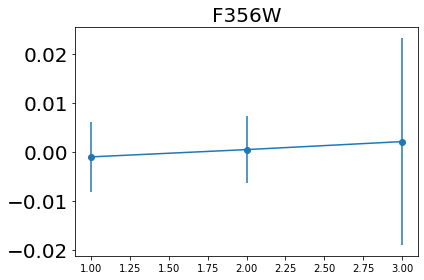

In [12]:
Fts=20
oshape=np.loadtxt(stamp_dirs+slicename+"_3mcoshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_3mcmshape.cat")
wwshape=np.loadtxt(stamp_dirs+slicename+"_3mcwshape.cat")
indx=np.where(oshape[:,5]>40)
deshape=[]
for index in indx[0]:
    deshape.append([oshape[index][0]-wshape[index][0],oshape[index][1]-wshape[index][1],(oshape[index][2]-wshape[index][2])/oshape[index][2]])
deshape=np.array(deshape);print(deshape.shape)
dwshape=[]
for index in indx[0]:
    dwshape.append([oshape[index][0]-wwshape[index][0],oshape[index][1]-wwshape[index][1],(oshape[index][2]-wwshape[index][2])/oshape[index][2]])
dwshape=np.array(dwshape);print(dwshape.shape)
print(np.mean(deshape[:,0]),np.std(deshape[:,0]))
print(np.mean(deshape[:,1]),np.std(deshape[:,1]))
print(np.mean(deshape[:,2]),np.median(deshape[:,2]),np.std(deshape[:,2]))
plt.errorbar([1,2,3],[np.mean(deshape[:,0]),np.mean(deshape[:,1]),np.mean(deshape[:,2])],
             yerr=[np.std(deshape[:,0]),np.std(deshape[:,1]),np.std(deshape[:,2])],marker='o')
'''plt.errorbar([1,2,3],[np.mean(dwshape[:,0]),np.mean(dwshape[:,1]),np.mean(dwshape[:,2])],
             yerr=[np.std(dwshape[:,0]),np.std(dwshape[:,1]),np.std(dwshape[:,2])],marker='o')
plt.xticks([1,2,3],['$\delta{e_1}$','$\delta{e_2}$','$\delta{R^2}/R^2$'],fontsize=Fts)'''
plt.yticks(fontsize=Fts)
#plt.legend(fontsize=Fts,loc='upper left')
plt.title(filte,fontsize=Fts)
plt.tight_layout()
plt.savefig("/home/lnie/code/JWST/co356W.pdf")

In [ ]:
#for F356W parallel field 
fn="/data/JWST_rev/coadd_img/rev4/parallel_field/F356Walong_it1_UPDC_rev4.fits"
catname="/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star/F356Walong_it0_UPDC_rev4_star.cat"
stampname="/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it0_UPDC_rev4_star.fits"
maskname="/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it0_UPDC_rev4_mask.fits"
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import ctypes
import webbpsf
import os
from scipy.stats import sigmaclip
from astropy.stats import SigmaClip
from astropy.wcs import WCS

from psf_fit import star_shape,write_fits,get_filename,\
web_psf_fit,web_psf_rec,int2cent,model2pos,wgtmap,gaus_estimate\
,write_mult_fits,polyfit2d
from C_tools_lib import centriod_psf
from mcmcs import coeff2psf,interp_cubic

def size(image,center,sigma):
    '''
    size(image,center,sigma)
    center[0]=cx;center[1]=cy
    '''
    nx=image.shape[0];ny=image.shape[1]
    #print("nx=%d,ny=%d"%(nx,ny))
    W=0;R11=0;R22=0;R12=0;R2=0.;k=0;
    nh=(np.min([nx,ny])*0.5)**2
    #print("nh=%d,cx=%f,cy=%f"%(nh,center[0],center[1]))
    scale=0.5/(sigma**2)
    for i in range(nx):
        for j in range(ny):
            x=i-center[0];y=j-center[1]
            r2=x**2+y**2;weight=np.exp(-r2*scale)
            if r2<nh:
                W=W+image[i][j]*weight
                R11=R11+x*x*image[i][j]*weight
                R22=R22+y*y*image[i][j]*weight
                R12=R12+x*y*image[i][j]*weight
                #if k<10 :print(image[i][j],weight,sigma)
                #k=k+1;
    R11=R11/W;R22=R22/W;R12=R12/W
    #print("message:w11=%f,w12=%f,w22=%f,w=%f"%(R11,R12,R22,W))
    e1=(R11-R22)/(R11+R22)
    e2=(2.*R12)/(R11+R22)
    #print("message")
    R2=R11+R22
    #print(e1,e2,R2)
    if R2<=0 : R2=0.001
    if R2<=0 or np.fabs(e1)>=1. or np.fabs(e2)>=1.:
        #raise Exception("R2<=0\n")
        print("R2<=0\n");
        return(e1,e2,R2)
    else:
        return(e1,e2,R2)

def S2N(image,gain=1):
    Ng1=image.shape[0]
    Ng2=image.shape[1]
    weight=np.zeros(image.shape,dtype='float')
    mean,sigma=gaus_estimate(image)
    #print("method=%f,sigma=%f"%(mean,sigma))
    for i in range(Ng1):
        for j in range(Ng2):
            detx=sigma*sigma*gain*gain
            dety=gain*np.fabs(image[i][j])
            if dety<detx : error=sigma
            else : error=np.sqrt(dety+detx)/gain
            #weight[i][j]=1./(error**2)
            weight[i][j]=error
    snr=np.sum(image)/np.sqrt(np.sum(weight**2))
    return(snr)

nrca_short_detectors = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']
nrca_long_detectors = ['NRCA5', 'NRCB5']
F090W_fname="jw02736001001_02101_"
F150W_fname="jw02736001001_02103_"
F200W_fname="jw02736001001_02105_"
F277W_fname="jw02736001001_02101_"
F356W_fname="jw02736001001_02103_"
F444W_fname="jw02736001001_02105_"
sdetect=["nrca1","nrca2","nrca3","nrca4","nrcb1","nrcb2","nrcb3","nrcb4"]
ldetect=["nrcalong","nrcblong"]
ldetect=["nrcalong"]
detector=dict({"nrca1":"nrca1","nrca2":"nrca2","nrca3":"nrca3","nrca4":"nrca4",
               "nrcb1":"nrcb1","nrcb2":"nrcb2","nrcb3":"nrcb3","nrcb4":"nrcb4",
               "nrcalong":"nrca5","nrcblong":"nrcb5"})
filte_name=dict({"F090W":"jw02736001001_02101_","F150W":"jw02736001001_02103_",
                "F200W":"jw02736001001_02105_","F277W":"jw02736001001_02101_",
                "F356W":"jw02736001001_02103_","F444W":"jw02736001001_02105_"})
f2detpath=dict({"F090W":sdetect,"F150W":sdetect,"F200W":sdetect,
                "F277W":ldetect,"F356W":ldetect,"F444W":ldetect})
gains=dict({"nrca1":"2.08","nrca2":"2.02","nrca3":"2.17","nrca4":"2.02",
            "nrcb1":"2.01","nrcb2":"2.14","nrcb3":"1.94","nrcb4":"2.03",
            "nrcalong":"1.84","nrcblong":"1.80"})




osam=2
npc=10

Cam="NIRCam/"
filte="F356W"
odirs="/data/SMACS0723_NIRCam_pipeline1.8.1/"+filte+'/'
dirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'
PCdirs="/home/lnie/data/PC/JWST/"+Cam+filte+'/'
stamp_dirs=dirs+"/catalogue/star_stamps/"
TNg=80
ikk=0
Nim=5
cent=np.zeros(2,dtype='float')
hdu0=fits.open(fn)
cat=np.loadtxt(catname)
readstar=fits.open(stampname)[0].data
mask=fits.open(maskname)[0].data
Nobj=readstar.shape[0];Ng0=readstar.shape[1]
shapes=np.zeros((Nobj,2),dtype='float')
XPOSURE=hdu0['SCI'].header['XPOSURE']
PHOTMJSR=hdu0['SCI'].header['PHOTMJSR']
readstar*=(PHOTMJSR*XPOSURE)
#clear the candidates
for ic in range(Nobj):
    rx=cat[ic][1]+0.5;ry=cat[ic][2]+0.5
    cent[0],cent[1],sigma=centriod_psf(readstar[ic])
    oe1,oe2,or2=size(readstar[ic],cent,3.);
    mage=(oe1**2+oe2**2)**0.5
    shapes[ic][0]=mage;shapes[ic][1]=or2
cleane,low,high=sigmaclip(shapes[:,0],3.,3.)
cleanr,low,high=sigmaclip(shapes[:,1],3.,3.)
print("clean Nobj=",cleane.shape[0])
spos=np.zeros((cleane.shape[0],2),dtype='float')
instar=np.zeros((cleane.shape[0],Ng0,Ng0),dtype='float')
wgt=np.zeros(instar.shape,dtype='float');print(instar.shape,wgt.shape)
k=0
for ic in range(Nobj):
    if k <cleane.shape[0] and shapes[ic][0]==cleane[k]:
        spos[k][0]=cat[ic][1];spos[k][1]=cat[ic][2]
        instar[k]=readstar[ic].T
        wgt[k]=mask[ic].T
        k+=1
Nobj=k;print("clean Nobj=",Nobj)


tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
print(stamp_dirs+slicename+"_comodel.fits")
#if os.path.exists(stamp_dirs+slicename+"_comodel1.fits"):
try:
    hdu=fits.open(stamp_dirs+slicename+"_comodel2.fits")
    comodel=hdu[0].data
except:
    #wmodel=np.zeros((9,Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    comodel=np.zeros((Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    for det in f2detpath[filte]:
        gain=float(gains[det])
        stamp_dirs=dirs+det+'/'+"catalogue/star_stamps/"
        for Tim in range(9):
            expos=Tim+1
            indx=str(int(expos/10000))+str(int(expos/1000)%10)+str(int(expos/100)%10)+str(int(expos/10)%10)+str(expos%10)
            ofname=(odirs+filte_name[filte]+indx+'_'+det+"_cal.fits");print(ofname)
            stamp_name=(stamp_dirs+filte_name[filte]+indx+'_'+det+"_cal_pv181_rev4_star.fits")
            tmpname=stamp_name.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len("_star.fits")]
            hdu=fits.open(ofname);OPD=hdu[0].header['DATE-BEG'];
            print("OPD:",OPD)
            PHOTUJA2=hdu['SCI'].header['PHOTUJA2'];XPOSURE=hdu['SCI'].header['XPOSURE']
            PHOTMJSR=hdu['SCI'].header['PHOTMJSR']
            PIXAR_A2=hdu['SCI'].header['PIXAR_A2']
            nrc = webbpsf.NIRCam()
            nrc.filter =filte
            if "nrcalong" in ofname:
                nrc.detector="NRCA5"
            if "nrcblong" in ofname:
                nrc.detector="NRCB5"
            nrc.load_wss_opd_by_date(OPD)
            print(filte,detector[det].upper(),OPD)
            for ic in range(Nobj):
                w = WCS(hdu0['SCI'].header)
                wcsx,wcsy=w.wcs_pix2world(spos[ic][0],spos[ic][1],1)
                w = WCS(hdu['SCI'].header)
                ipx,ipy=w.wcs_world2pix(wcsx,wcsy,1)
                print(spos[ic][0],spos[ic][1],ipx,ipy)
                if(ipx>0 and ipx<2047 and ipy>0 and ipy<2047):
                    nrc.detector_position=(ipx,ipy)
                    psf = nrc.calc_psf(fov_pixels=int((Ng0+Nim+1)/2),oversample=4)
                    psf.info()
                    psf=(psf[2].data/np.sum((psf[2].data))).T 
                    print(comodel[ic].shape,psf.shape,)
                    comodel[ic,:,:]+=psf[1:((Ng0+Nim+1)*2-1),1:((Ng0+Nim+1)*2-1)]
                print(ic)
                
    for ic in range(Nobj):
        comodel[ic]/=np.sum(comodel[ic])
    stamp_dirs=dirs+"/catalogue/star_stamps/"
    tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
    write_fits(stamp_dirs+slicename+"_comodel1.fits",comodel)


'''for ic in range(Nobj):
    plt.subplot(1,2,1)
    plt.imshow(instar[ic]**0.1)
    plt.subplot(1,2,2)
    plt.imshow(comodel[ic,40:121,40:121]**0.1);
    plt.show()'''
    

tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")]  
print(fn)
if "blong" in fn : detect="nrcblong"
if "along" in fn : detect="nrcalong"
PCs,pos,coeff,getNobj,slecstar,webcoeff=web_psf_fit(
    instar,
    spos,
    npc,
    gain=float(gains[detect]),
    method=1,
    wgt=wgt,
    imodel=comodel,
    osam=2,
    SNRs=10.)
polyorder=2
if getNobj>10:polyorder=3
if getNobj>15:polyorder=4
if getNobj>21:polyorder=5
rPSF=coeff2psf(pos,coeff,PCs,pos,degrees=polyorder);print("rPSF",rPSF.shape)
icoeff=polyfit2d(pos,webcoeff[:,0],webcoeff[:,1],pos,3)
eNg=rPSF.shape[1]
Ng=int(eNg/osam)
sNg=30;dpix=int((slecstar.shape[1]-sNg)/2);cut=int(((Ng0+Nim)*osam-eNg)/2)
mix_mod=np.zeros(rPSF.shape,dtype='float')
rrPSF=np.zeros((getNobj,sNg,sNg),dtype='float')
chi1=np.zeros((getNobj,sNg,sNg))
chi2=np.zeros((getNobj,sNg,sNg))
residu1=np.zeros((getNobj,sNg,sNg))
residu2=np.zeros((getNobj,sNg,sNg))
fp=open(stamp_dirs+slicename+"_cooshape.cat","w")
fpw=open(stamp_dirs+slicename+"_cowshape.cat","w")
fpm=open(stamp_dirs+slicename+"_comshape.cat","w")
for ic in range(getNobj):
    mean,sigma=gaus_estimate(slecstar[ic]);
    print(ic,mean,sigma)
    #mean,sigma=gaus_estimate(rPSF[ic]);rPSF[ic]-=mean
    slecstar[ic]-=mean
    #slecstar[ic]*=wgt[ic]
    snrs=S2N(slecstar[ic],gain=1.84)
    slecstar[ic]/=np.sum(slecstar[ic])
    tmp=wgtmap(slecstar[ic])
    tmp_img=slecstar[ic][dpix:dpix+sNg,dpix:dpix+sNg]
    tmp_wgt=wgt[ic][dpix:dpix+sNg,dpix:dpix+sNg]#mask
    tmp_img*=tmp_wgt
    #tmp_img/=np.sum(tmp_img) #normalise
    error_map=tmp[dpix:dpix+sNg,dpix:dpix+sNg];#error_map/=sums  #weight map
    tmp_wmap=1./(error_map*error_map)*tmp_wgt;
    cent[0],cent[1],sigma=centriod_psf(tmp_img);
    print(cent[0],cent[1])
    dx=cent[0]-(sNg/2.+0.5)+1;dy=cent[1]-(sNg/2.+0.5)+1
    rrPSF[ic]=interp_cubic(rPSF[ic],sNg,dy,dx,osam=2)
    tmp_mod=interp_cubic(comodel[ic],sNg,dy,dx,osam=1)
    #print("sum:", np.sum(rrPSF[ic]))
    #mean,sigma=gaus_estimate(rrPSF[ic]);rrPSF[ic]-=mean
    rrPSF[ic]=rrPSF[ic].T;
    tmp_mod*=tmp_wgt;
    frac=(1.-np.sum(comodel[ic,cut:cut+eNg,cut:cut+eNg]))
    #rPSF=rPSF/np.sum(rPSF)*frac
    #tmp_mod/=np.sum(tmp_mod)
    for i in range(eNg):
        for j in range(eNg):
            mix_mod[ic][i][j]=0
            mix_mod[ic][i][j]=(rPSF[ic][i][j]+comodel[ic][i+cut][j+cut]*icoeff[ic])#mixture model
            if mix_mod[ic][i][j]<0 : mix_mod[ic][i][j]=0
    for i in range(eNg):
        for j in range(eNg):
            if mix_mod[ic][i][j]==0 and i-1>0 and i+1<eNg and j-1>0 and j+1<eNg:
                mix_mod[ic][i][j]=(mix_mod[ic][i-1][j-1]+mix_mod[ic][i-1][j]+mix_mod[ic][i-1][j+1]+
                                   mix_mod[ic][i][j-1]+mix_mod[ic][i][j+1]+
                                   mix_mod[ic][i+1][j-1]+mix_mod[ic][i+1][j]+mix_mod[ic][i+1][j+1])/8.
    tmp_mix_mod=interp_cubic(mix_mod[ic],sNg,dy,dx,osam)
    tmp_mix_mod*=tmp_wgt;
    print(np.sum(tmp_img),np.sum(tmp_mix_mod))
    #mean,sigma=gaus_estimate(tmp_mix_mod);tmp_mix_mod-=mean
    tmp_img/=np.sum(tmp_img);tmp_mod/=np.sum(tmp_mod);tmp_mix_mod/=np.sum(tmp_mix_mod)
    residu1[ic]=(tmp_img-tmp_mod).T
    residu2[ic]=(tmp_img-tmp_mix_mod).T
    oe1,oe2,or2=size(tmp_img,cent,3.);
    we1,we2,wr2=size(tmp_mod,cent,3.);
    me1,me2,mr2=size(tmp_mix_mod,cent,3.);
    print(oe1,oe2,or2)
    print(me1,me2,mr2)
    fpw.writelines(str(we1)+'\t'+str(we2)+'\t'+str(wr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fp.writelines(str(oe1)+'\t'+str(oe2)+'\t'+str(or2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fpm.writelines(str(me1)+'\t'+str(me2)+'\t'+str(mr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    chi1[ic]=residu1[ic]*residu1[ic]*tmp_wmap
    chi2[ic]=residu2[ic]*residu2[ic]*tmp_wmap
#write_fits("fits/rPSF.fits",rrPSF)
fp.close();fpw.close();fpm.close()
write_fits(stamp_dirs+slicename+"_cowebchi.fits",chi1)
write_fits(stamp_dirs+slicename+"_comixchi.fits",chi2)
write_fits(stamp_dirs+slicename+"_cowebresidu.fits",residu1)
write_fits(stamp_dirs+slicename+"_comixresidu.fits",residu2)  
#write_fits("fits/ostars.fits",instar)
oshape=np.loadtxt(stamp_dirs+slicename+"_cooshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_comshape.cat")
de1=oshape[:,0]-wshape[:,0];de2=oshape[:,1]-wshape[:,1];dr=(oshape[:,2]**0.5-wshape[:,2]**0.5)
print(np.mean(oshape[:,0]),np.mean(oshape[:,1]),np.mean(oshape[:,2]))
print(np.mean(de1),np.std(de1),np.mean(de2),np.std(de2),np.median(dr),np.std(dr),
      np.mean((oshape[:,2]-wshape[:,2])/oshape[:,2]))

   



clean Nobj= 63
(63, 80, 80) (63, 80, 80)
clean Nobj= 63
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it1_UPDC_rev4_comodel.fits
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00001_nrcalong_cal.fits
OPD: 2022-06-07T02:56:26.660

MAST OPD query around UTC: 2022-06-07T02:56:26.660
                        MJD: 59737.12253078703

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2095 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9356 days
User requested choosing OPD time closest in time to 2022-06-07T02:56:26.660, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.936 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field p

Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
0
2.69675e+03 972.0688 1173.6433019702033 320.82280669558133


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
1
3.108102e+03 1031.183 1377.9725113473241 349.08438458002354


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
2
2.616859e+03 4514.688 1147.8144888399904 2080.778847834385
3
2979.344 3925.555 1325.3704747459396 1787.164513531634


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
4
7.83662e+02 2598.346 230.77440973169428 1133.7785577352663


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
5
2.842413e+03 1774.615 1249.0448937605759 719.0849572273507


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
6
2.109703e+03 1160.165 883.1039684270563 415.8301091090723


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
7
8.382734e+02 3182.606 260.148363190656 1423.8544107142857


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
8
3.390514e+03 3849.881 1529.0839306486334 1748.4726018643203


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
9
2.353174e+03 2401.018 1008.7432094873966 1031.55231761195


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
10
1.439271e+03 2366.147 555.1599293378363 1016.6801053533951


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
11
3.557921e+03 885.6355 1600.5898849908065 275.5802939238097


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
12
4.530317e+03 1708.806 2086.2684525053105 681.8714575544618
13


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4527.345 3284.679 2090.93714932766 1464.6702398588395
14
1345.52 3499.23 513.0610486960813 1579.7730295733418
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
15
1.226032e+03 1713.323 446.81311203494647 692.9712841409225


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
16
3.102922e+03 3109.355 1383.5038105729475 1381.398432513013


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
17
2.635258e+03 324.1862 1140.6074076178386 -0.838158799322855
18
4501.505 3254.53 2077.9986958018076 1449.7634409332818
19
1381.082 1401.837 522.5293262349364 537.8298146565796


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
20
7.649799e+02 1209.693 216.09153945467938 444.03648468359097


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
21
2.288297e+03 1426.111 972.7529392530132 547.456054222416


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
22
2.245181e+03 4494.079 963.3202649594275 2071.537805832939
23
3969.164 3216.592 1813.7214441922165 1432.3450887852796


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
24
2.431785e+03 2317.524 1047.4218043092953 989.867258216895


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
25
8.939545e+02 4120.859 291.43305302909425 1889.7680066847124


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
26
2.032451e+03 1525.934 846.2000690044752 597.7273162499874


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
27
4.278826e+03 727.6732 1957.66244207834 195.1827821322529


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
28
4.388469e+03 3111.365 2021.3560003712637 1378.9513729880482


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
29
4.007685e+03 2940.14 1831.7565378310182 1294.918541704665


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
30
3.070476e+03 4479.064 1372.7448199305454 2061.8673957219307
31
1233.795 3070.505 455.9556142764852 1367.1098843019415


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
32
2.175699e+03 2539.288 921.2252227424037 1100.7114906844702


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
33
3.426901e+03 3705.318 1546.574355856466 1676.5656183870817


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
34
2.052205e+03 355.4119 851.4382241612748 16.235416749643377


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
35
3.235373e+02 2785.36 3.2053519149237673 1227.908119318803


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
36
2.25275e+03 1907.562 956.9925999154647 786.7047491481198


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
37
1.125454e+03 3147.241 402.4996675398031 1405.517692255733


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
38
2.542346e+03 4096.088 1109.2118440010393 1873.0454066627801


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
39
4.251558e+03 613.7711 1943.6889651733568 138.6767387072955


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
40
1.784994e+03 4182.511 733.7766498527737 1918.0045494944593


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
41
2.161942e+03 595.3821 906.8214492324951 135.14282949537892


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
42
1.707743e+03 1542.598 685.156052162296 606.8751790747742


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
43
1.49851e+03 3343.783 588.3634558333042 1502.1470685919705


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
44
3.966365e+03 2139.655 1808.134401144132 897.4006028084775


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
45
2.71742e+03 3629.241 1194.2576293604832 1640.6770680888644


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
46
1.883855e+03 801.8024 769.6489105574606 238.4242802366548


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
47
5.31425e+02 2853.182 106.61649620553635 1261.0404844955422


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
48
2.145821e+03 1390.598 901.9227899622288 530.1973756988986


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
49
2.525196e+03 3530.996 1098.4996766177876 1592.390561318844


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
50
3.961978e+03 2582.223 1807.683006200412 1117.2512476506236


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
51
1.418097e+03 884.5473 538.8783251231745 280.774859002733


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
52
3.883102e+03 2827.293 1769.502806934568 1239.1974247105716


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
53
2.490903e+03 3697.518 1082.133826254973 1675.1997299865384


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
54
3.959198e+03 3271.023 1808.9888475954256 1459.409566419747


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
55
1.160256e+03 3349.729 420.55659565146163 1506.0072344966366


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
56
5.943495e+02 745.6306 129.62150729601535 213.97790331612634


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
57
1.836737e+03 3645.114 757.3547922267851 1650.9221263537042


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
58
4.637887e+02 4315.682 78.75901662990486 1987.6962743782865


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
59
1.421063e+03 4044.011 552.6666416758219 1850.1821925230963


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
60
1.869408e+03 1536.287 765.3440809622632 603.3069951541773


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
61
1.743831e+03 4512.199 714.6382188421805 2081.8823465794735
62
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00002_nrcalong_cal.fits
OPD: 2022-06-07T03:12:00.739


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:03:30.763' from MJD-AVG.
Set DATE-END to '2022-06-07T03:10:34.865' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882243 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675123423.934 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]



MAST OPD query around UTC: 2022-06-07T03:12:00.739
                        MJD: 59737.133341886576

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2203 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9248 days
User requested choosing OPD time closest in time to 2022-06-07T03:12:00.739, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.925 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCA5 2022-06-07T03:12:00.739
2136.117 4336.148 905.4785789391251 2088.5330507245817
0
2696.75 972.0688 1170.5288075797132 415.97517544577465


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
1
3.108102e+03 1031.183 1374.8580548288655 444.2364752784613


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
2
2.616859e+03 4514.688 1144.7024135182373 2175.9312677072476
3
2979.344 3925.555 1322.2579972955612 1882.3166853656844


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
4
7.83662e+02 2598.346 227.66103048712125 1228.9322094801455


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
5
2.842413e+03 1774.615 1245.9309467359756 814.2372222227593


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
6
2.109703e+03 1160.165 879.989605814759 510.98287243467075


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
7
8.382734e+02 3182.606 257.0353804296899 1519.0080256224965


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
8
3.390514e+03 3849.881 1525.9714014997576 1843.6244958388977


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
9
2.353174e+03 2401.018 1005.6296918801204 1126.7049104717662


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
10
1.439271e+03 2366.147 552.0463906520412 1111.8333150562278


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
11
3.557921e+03 885.6355 1597.475326054976 370.7320823827788


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
12
4.530317e+03 1708.806 2083.154452570332 777.0225838960928
13
4527.345 3284.679 2087.8242318518783 1559.8213649679801
14
1345.52 3499.23 509.94828069620223 1674.9263027389948


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
15
1.226032e+03 1713.323 443.69913027532857 788.1246401903845


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
16
3.102922e+03 3109.355 1380.3907750363123 1476.55051883789


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
17
2.635258e+03 324.1862 1137.4924713109303 94.31425790720027


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
18
4.501505e+03 3254.53 2074.885757654403 1544.9145834430233
19
1381.082 1401.837 519.4151320121607 632.9830679067247


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
20
7.649799e+02 1209.693 212.97721788051751 539.1901549881272


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
21
2.288297e+03 1426.111 969.6387569893552 642.6086951490976


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
22
2.245181e+03 4494.079 960.2081749689871 2166.6904764736696
23
3969.164 3216.592 1810.6084807863742 1527.4965905513454


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
24
2.431785e+03 2317.524 1044.3082295016466 1085.0197982290751


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
25
8.939545e+02 4120.859 288.3207072551743 1984.9215871715523


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
26
2.032451e+03 1525.934 843.0859560551057 692.8801291876194


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
27
4.278826e+03 727.6732 1954.547770011364 290.3340856751445


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
28
4.388469e+03 3111.365 2018.2429640902947 1474.1025916521173


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
29
4.007685e+03 2940.14 1828.643384787757 1390.0700173197156


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
30
3.070476e+03 4479.064 1369.6327209674475 2157.0195091253886
31
1233.795 3070.505 452.8425549155311 1462.2632321388407


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
32
2.175699e+03 2539.288 918.1117999218937 1195.8642030476615


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
33
3.426901e+03 3705.318 1543.461727751371 1771.7174872672933


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
34
2.052205e+03 355.4119 848.3233135112566 111.38822646935057


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
35
3.235373e+02 2785.36 0.09210043003804458 1323.0620814497136


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
36
2.25275e+03 1907.562 953.8787461212851 881.8574114255189


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
37
1.125454e+03 3147.241 399.3866604587861 1500.6711132890039


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
38
2.542346e+03 4096.088 1106.0994828217963 1968.197874294975


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
39
4.251558e+03 613.7711 1940.5742151359154 233.82806179008617


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
40
1.784994e+03 4182.511 730.6643469301696 2013.157528834258


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
41
2.161942e+03 595.3821 903.706701342069 230.29556261374523


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
42
1.707743e+03 1542.598 682.0419521135337 702.028211019036


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
43
1.49851e+03 3343.783 585.2505820249567 1597.3002381350448


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
44
3.966365e+03 2139.655 1805.0206993278339 992.5521077601916


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
45
2.71742e+03 3629.241 1191.1449494623323 1735.8294156181105


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
46
1.883855e+03 801.8024 766.5343051539865 333.57719897763786


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
47
5.31425e+02 2853.182 103.50329034195556 1356.194306304478


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
48
2.145821e+03 1390.598 898.8085842149382 625.350112998642


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
49
2.525196e+03 3530.996 1095.3869297254487 1687.5430383124806


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
50
3.961978e+03 2582.223 1804.5696078440633 1212.402754414202


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
51
1.418097e+03 884.5473 535.7637789440766 375.92809125209897


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
52
3.883102e+03 2827.293 1766.3895767927897 1334.3489844421774


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
53
2.490903e+03 3697.518 1079.0211930255539 1770.3522306356917


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
54
3.959198e+03 3271.023 1805.8759215265945 1554.5610749826005


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
55
1.160256e+03 3349.729 417.4437261288617 1601.1606323595852


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
56
5.943495e+02 745.6306 126.50687188864538 309.1316926214024


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
57
1.836737e+03 3645.114 754.2421233688456 1746.0750683852045


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
58
4.637887e+02 4315.682 75.64680248473519 2082.850146392788
59
1421.063 4044.011 549.5542441663267 1945.3354167916204


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
60
1.869408e+03 1536.287 762.2299758481242 698.4599180469295


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
61
1.743831e+03 4512.199 711.5261403452425 2177.0353557962217
62
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00003_nrcalong_cal.fits
OPD: 2022-06-07T03:27:34.882


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:19:04.842' from MJD-AVG.
Set DATE-END to '2022-06-07T03:26:08.944' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.885954 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675184204.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]



MAST OPD query around UTC: 2022-06-07T03:27:34.882
                        MJD: 59737.144153726855

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2311 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9140 days
User requested choosing OPD time closest in time to 2022-06-07T03:27:34.882, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.914 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCA5 2022-06-07T03:27:34.882
2136.117 4336.148 1001.096901916904 2091.7807622827927
0
2696.75 972.0688 1266.1475520436607 419.22295322028754


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
1
3.108102e+03 1031.183 1470.4767932847508 447.48430298416156


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
2
2.616859e+03 4514.688 1240.3207148553752 2179.1790413227436
3
2979.344 3925.555 1417.8763734574263 1885.564504123879


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
4
7.83662e+02 2598.346 323.27957456325134 1232.1797513781164


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
5
2.842413e+03 1774.615 1341.5495912777144 817.4850190785163


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
6
2.109703e+03 1160.165 975.6083260565549 514.2305791692834


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
7
8.382734e+02 3182.606 352.65385103888343 1522.255572986187


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
8
3.390514e+03 3849.881 1621.5897891302943 1846.8723667522968


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
9
2.353174e+03 2401.018 1101.248257048438 1129.9526477877923


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
10
1.439271e+03 2366.147 647.6649609863271 1115.0809389135097


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
11
3.557921e+03 885.6355 1693.094085050704 373.9799641134506


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
12
4.530317e+03 1708.806 2178.7731168977884 780.2705876292662
13
4527.345 3284.679 2183.44269942881 1563.0693772831169
14
1345.52 3499.23 605.566709494228 1678.1739136195624


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
15
1.226032e+03 1713.323 539.3177830421413 791.3722386247167


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
16
3.102922e+03 3109.355 1476.0092537356593 1479.7983511044208


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
17
2.635258e+03 324.1862 1233.111296638884 97.5620274445123


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
18
4.501505e+03 3254.53 2170.5042287202446 1548.1625923271454
19
1381.082 1401.837 615.0338232181374 636.230685785019


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
20
7.649799e+02 1209.693 308.5959359630581 542.4376982110817


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
21
2.288297e+03 1426.111 1065.2574440248786 645.8564237340848


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
22
2.245181e+03 4494.079 1055.8264782609517 2169.938202200511
23
3969.164 3216.592 1906.2269515847734 1530.7445321891826


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
24
2.431785e+03 2317.524 1139.9268052118607 1088.267545216244


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
25
8.939545e+02 4120.859 383.9390600879075 1988.1691396331576


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
26
2.032451e+03 1525.934 938.7046305594126 696.1278265498449


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
27
4.278826e+03 727.6732 2050.166554332932 293.58205375429793
28
4388.469 3111.365 2113.8614518644454 1477.350585508601
29
4007.685 2940.14 1924.2618904317696 1393.3179625235364


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
30
3.070476e+03 4479.064 1465.2510283327306 2160.2673410528887
31
1233.795 3070.505 548.461037761314 1465.510829459443


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
32
2.175699e+03 2539.288 1013.7303476658276 1199.1119184009017


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
33
3.426901e+03 3705.318 1639.0801336591085 1774.9653623078439


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
34
2.052205e+03 355.4119 943.9421344354803 114.6359262413672


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
35
3.235373e+02 2785.36 95.71062416280984 1326.3095653472315


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
36
2.25275e+03 1907.562 1049.497372917474 885.1051359467348


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
37
1.125454e+03 3147.241 495.0051341217768 1503.9186968713645


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
38
2.542346e+03 4096.088 1201.7178363272676 1971.445637615477


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
39
4.251558e+03 613.7711 2036.1930134270635 237.07602604259375


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
40
1.784994e+03 4182.511 826.2826892685382 2016.4051953048724


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
41
2.161942e+03 595.3821 999.3254922306554 233.54327556239798


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
42
1.707743e+03 1542.598 777.6606248844043 705.2758686653547


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
43
1.49851e+03 3343.783 680.8690298448039 1600.5478685016178


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
44
3.966365e+03 2139.655 1900.6393046022981 995.8000442146661


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
45
2.71742e+03 3629.241 1286.7633617705524 1739.0772004032542


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
46
1.883855e+03 801.8024 862.1530703604775 336.8248784040469


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
47
5.31425e+02 2853.182 199.12180407460983 1359.4418159991196


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
48
2.145821e+03 1390.598 994.4272756331236 628.5978241823435


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
49
2.525196e+03 3530.996 1191.0053538547863 1690.7907985674638


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
50
3.961978e+03 2582.223 1900.1881578102818 1215.65069228306


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
51
1.418097e+03 884.5473 631.3825347780823 379.1757143413457


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
52
3.883102e+03 2827.293 1862.0080955209244 1337.5969135438568


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
53
2.490903e+03 3697.518 1174.6395962668466 1773.599986785951


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
54
3.959198e+03 3271.023 1901.4943854452845 1557.809015614614


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
55
1.160256e+03 3349.729 513.0621743022526 1604.4082200103792


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
56
5.943495e+02 745.6306 222.12564917033853 312.3792165613801


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
57
1.836737e+03 3645.114 849.8605328879671 1749.322741449429


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
58
4.637887e+02 4315.682 171.2651334941918 2086.0976432474145
59
1421.063 4044.011 645.1726045542568 1948.583036762473


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
60
1.869408e+03 1536.287 857.8486491763964 701.7075954698853


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
61
1.743831e+03 4512.199 807.1444414840709 2180.283016974233
62
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00004_nrcalong_cal.fits
OPD: 2022-06-07T03:42:58.210


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:34:38.985' from MJD-AVG.
Set DATE-END to '2022-06-07T03:41:43.087' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.889432 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675241176.190 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]



MAST OPD query around UTC: 2022-06-07T03:42:58.210
                        MJD: 59737.154840393516

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2418 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9033 days
User requested choosing OPD time closest in time to 2022-06-07T03:42:58.210, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.903 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCA5 2022-06-07T03:42:58.210
2136.117 4336.148 1004.2013321385791 1996.6233427262198


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
0
2.69675e+03 972.0688 1269.2583630926115 324.06654475839275


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
1
3.108102e+03 1031.183 1473.5874994857909 352.3286663050162


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
2
2.616859e+03 4514.688 1243.4248116138992 2084.0225232856137
3
2979.344 3925.555 1420.9815906085237 1790.4086624468769


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
4
7.83662e+02 2598.346 326.3872773379335 1137.019783744683


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
5
2.842413e+03 1774.615 1344.658883782884 722.328897439186


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
6
2.109703e+03 1160.165 978.7187706376204 419.07307439389535


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
7
8.382734e+02 3182.606 355.76044972113584 1427.0957138090462


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
8
3.390514e+03 3849.881 1624.695154392114 1751.7172950283807


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
9
2.353174e+03 2401.018 1104.3563552517412 1034.795618408054


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
10
1.439271e+03 2366.147 650.7731121351931 1019.9221967850473


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
11
3.557921e+03 885.6355 1696.2050752201053 278.825167359484


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
12
4.530317e+03 1708.806 2181.8825612994196 685.1176273198098
13
4527.345 3284.679 2186.5491510865604 1467.9164312428725
14
1345.52 3499.23 608.6727153823833 1583.0150075805866


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
15
1.226032e+03 1713.323 542.4271661810221 696.2130876530583


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
16
3.102922e+03 3109.355 1479.1160197647923 1384.6427344774852


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
17
2.635258e+03 324.1862 1236.2233342581912 2.4054904891202114


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
18
4.501505e+03 3254.53 2173.610737303481 1453.0095975940078
19
1381.082 1401.837 618.1437981645137 541.0718201987306


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
20
7.649799e+02 1209.693 311.7062641607082 447.27767499311426


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
21
2.288297e+03 1426.111 1068.367387914129 550.6992582467021


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
22
2.245181e+03 4494.079 1058.9306104390046 2074.780987631666
23
3969.164 3216.592 1909.3335253533762 1435.590539657143


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
24
2.431785e+03 2317.524 1143.0350627214323 993.1106620388314


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
25
8.939545e+02 4120.859 387.04388508074396 1893.0093915078064


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
26
2.032451e+03 1525.934 941.8143812179028 600.9701834089143


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
27
4.278826e+03 727.6732 2053.2778573199157 198.4286044343097
28
4388.469 3111.365 2116.96823083482 1382.1973776101486
29
4007.685 2940.14 1927.368989387463 1298.1640394073954


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
30
3.070476e+03 4479.064 1468.3551970789838 2065.1116728829065
31
1233.795 3070.505 551.5678534325697 1370.351710303582


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
32
2.175699e+03 2539.288 1016.8381814531981 1103.9545582262829


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
33
3.426901e+03 3705.318 1642.185773526614 1679.810357772118


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
34
2.052205e+03 355.4119 947.0541019098919 19.47829766925713


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
35
3.235373e+02 2785.36 98.81796724451874 1231.1487377245712


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
36
2.25275e+03 1907.562 1052.606404324285 789.9479115673967


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
37
1.125454e+03 3147.241 498.1118032631231 1408.759375452581


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
38
2.542346e+03 4096.088 1204.8227255155543 1876.2889780868497


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
39
4.251558e+03 613.7711 2039.3045321451566 141.92252329481266


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
40
1.784994e+03 4182.511 829.3874068189208 1921.247117106649


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
41
2.161942e+03 595.3821 1002.4370073062323 138.38585766666665


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
42
1.707743e+03 1542.598 780.7703387458996 610.1176174491482


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
43
1.49851e+03 3343.783 683.9753317134492 1505.389247844304


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
44
3.966365e+03 2139.655 1903.7479221985964 900.6460337975839


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
45
2.71742e+03 3629.241 1289.8691375757317 1643.920865929296


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
46
1.883855e+03 801.8024 865.2641895631056 241.66694370184973


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
47
5.31425e+02 2853.182 202.22902168930557 1264.2813786175122


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
48
2.145821e+03 1390.598 997.5372844323708 533.440391156357


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
49
2.525196e+03 3530.996 1194.111313557567 1595.634103166672


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
50
3.961978e+03 2582.223 1903.2959354217046 1120.4966794568734


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
51
1.418097e+03 884.5473 634.4934891531794 284.0169086776026


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
52
3.883102e+03 2827.293 1865.1154069503473 1242.4427557791525


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
53
2.490903e+03 3697.518 1177.7452400610052 1678.4432283768542


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
54
3.959198e+03 3271.023 1904.6008557839095 1462.6550049130326


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
55
1.160256e+03 3349.729 516.1684608281236 1509.2489656139446


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
56
5.943495e+02 745.6306 225.23685178880828 217.2188649120344


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
57
1.836737e+03 3645.114 852.9662683878644 1654.1647569250176


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
58
4.637887e+02 4315.682 174.3695857997243 1990.9370899870146


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
59
1.421063e+03 4044.011 648.2775804364219 1853.4242759163624


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
60
1.869408e+03 1536.287 860.9583775940262 606.549647034811


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
61
1.743831e+03 4512.199 810.2485344967236 2085.124863029218
62
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00005_nrcalong_cal.fits
OPD: 2022-06-07T03:58:21.601


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T03:50:02.313' from MJD-AVG.
Set DATE-END to '2022-06-07T03:57:06.415' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.893141 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675301934.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]



MAST OPD query around UTC: 2022-06-07T03:58:21.601
                        MJD: 59737.16552778935

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2525 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8926 days
User requested choosing OPD time closest in time to 2022-06-07T03:58:21.601, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.893 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F356W NRCA5 2022-06-07T03:58:21.601
2136.117 4336.148 1007.3091966722905 1901.4668802631065


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
0
2.69675e+03 972.0688 1272.3705394836552 228.91076304406602


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
1
3.108102e+03 1031.183 1476.6996057326191 257.1734061721518


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
2
2.616859e+03 4514.688 1246.5324504841776 1988.8666696013893


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
3
2.979344e+03 3925.555 1424.0899865059787 1695.2532666288728


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
4
7.83662e+02 2598.346 329.4973520957652 1041.8616005845643


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
5
2.842413e+03 1774.615 1347.7700341145887 627.1733115320258


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
6
2.109703e+03 1160.165 981.8306984266011 323.91655258344883


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
7
8.382734e+02 3182.606 358.86977912017073 1331.9376041066712


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
8
3.390514e+03 3849.881 1627.8036502933262 1656.5624194928541


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
9
2.353174e+03 2401.018 1107.4666980407997 939.6394201792749


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
10
1.439271e+03 2366.147 653.8834900382161 924.764841375855


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
11
3.557921e+03 885.6355 1699.3173742475774 183.67047420903953


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
12
4.530317e+03 1708.806 2184.9938164647247 589.9641770572956
13
4527.345 3284.679 2189.6583816789944 1372.762992184564
14
1345.52 3499.23 611.7816445165886 1487.8575417387565


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
15
1.226032e+03 1713.323 545.5383758396249 601.0554550233484


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
16
3.102922e+03 3109.355 1482.2254626123374 1289.4874911242168


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
17
2.635258e+03 324.1862 1239.336339426576 -92.75038034347244
18
4501.505 3254.53 2176.7200063973423 1357.8561256399162
19
1381.082 1401.837 621.2554076559337 445.91437967971024


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
20
7.649799e+02 1209.693 314.8181112777406 352.11945189745165


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
21
2.288297e+03 1426.111 1071.4789776971832 455.54296635577623


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
22
2.245181e+03 4494.079 1062.038273527623 1979.6246633804776


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
23
3.969164e+03 3216.592 1912.4428384178743 1340.4363935733206


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
24
2.431785e+03 2317.524 1146.14551321172 897.9545624915436


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
25
8.939545e+02 4120.859 390.1520169998257 1797.8513561141376


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
26
2.032451e+03 1525.934 944.9258401031614 505.8135690566686


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
27
4.278826e+03 727.6732 2056.390369284677 103.27482104956061
28
4388.469 3111.365 2120.0776828075855 1287.0437616367424
29
4007.685 2940.14 1930.4786576480915 1203.0099401820082


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
30
3.070476e+03 4479.064 1471.4628842685077 1969.9563934710632


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
31
1.233795e+03 3070.505 554.6773293956114 1275.1941005753301


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
32
2.175699e+03 2539.288 1019.9483454722449 1008.7981366435017


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
33
3.426901e+03 3705.318 1645.2944550771192 1584.6555277562854


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
34
2.052205e+03 355.4119 950.1670584074072 -75.67831050369409
35
323.5373 2785.36 101.92779901220536 1135.989973655973


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
36
2.25275e+03 1907.562 1055.7173775502938 694.7915809020449


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
37
1.125454e+03 3147.241 501.2211802656784 1313.6016290729413


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
38
2.542346e+03 4096.088 1207.9308999361353 1781.133029494562


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
39
4.251558e+03 613.7711 2042.4171899731775 46.76870340572816


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
40
1.784994e+03 4182.511 832.4954656709974 1826.0902098878132


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
41
2.161942e+03 595.3821 1005.5496584025759 43.22939273041038


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
42
1.707743e+03 1542.598 783.88177234806 514.9605923254918


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
43
1.49851e+03 3343.783 687.0844607261452 1410.2319748788545


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
44
3.966365e+03 2139.655 1906.8586174694874 805.4918748599653


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
45
2.71742e+03 3629.241 1292.977911112136 1548.7651374270679


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
46
1.883855e+03 801.8024 868.3765726966005 146.51013034221182


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
47
5.31425e+02 2853.182 205.33876884156916 1169.1228782279563


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
48
2.145821e+03 1390.598 1000.64891786726 438.28391843021495


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
49
2.525196e+03 3530.996 1197.2202113878664 1500.4781308704828


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
50
3.961978e+03 2582.223 1906.406062624852 1025.3425194078131


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
51
1.418097e+03 884.5473 637.6057601235477 188.8595071821594


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
52
3.883102e+03 2827.293 1868.225218841735 1147.2884979736702


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
53
2.490903e+03 3697.518 1180.8539244221777 1583.287213399367


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
54
3.959198e+03 3271.023 1907.710098899256 1367.500846548987


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
55
1.160256e+03 3349.729 519.2775794787121 1414.0912644791788


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
56
5.943495e+02 745.6306 228.34928889402386 122.06041852664237


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
57
1.836737e+03 3645.114 856.0750148297926 1559.0079135902633


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
58
4.637887e+02 4315.682 177.47746641389654 1895.778510305779


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
59
1.421063e+03 4044.011 651.3858139621645 1758.2669076668183


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
60
1.869408e+03 1536.287 864.0698212393518 511.39282645182107


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
61
1.743831e+03 4512.199 813.3561715217317 1989.9679040604858


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:05:25.704' from MJD-AVG.
Set DATE-END to '2022-06-07T04:12:29.806' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.896617 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675358884.676 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
62
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00006_nrcalong_cal.fits
OPD: 2022-06-07T04:13:44.928

MAST OPD query around UTC: 2022-06-07T04:13:44.928
                        MJD: 59737.176214444444

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2632 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8820 days
User requested choosing OPD time closest in time to 2022-06-07T04:13:44.928, which 

Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
0
2.69675e+03 972.0688 1176.7562871004147 225.6655279765763


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
1
3.108102e+03 1031.183 1381.0854401103347 253.92754539250222


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
2
2.616859e+03 4514.688 1150.9236542890521 1985.6215291972403


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
3
2.979344e+03 3925.555 1328.4802793683336 1692.007577548955


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
4
7.83662e+02 2598.346 233.88561457877609 1038.6192677888464


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
5
2.842413e+03 1774.615 1252.1570161645277 623.9278488059349


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
6
2.109703e+03 1160.165 886.2167405278457 320.67220862793556


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
7
8.382734e+02 3182.606 263.25894136372926 1328.6951859458845


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
8
3.390514e+03 3849.881 1532.193821727179 1653.316103540273


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
9
2.353174e+03 2401.018 1011.8546492057635 936.3946976144815


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
10
1.439271e+03 2366.147 558.2713931152775 921.5215109055672


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
11
3.557921e+03 885.6355 1603.702978989667 180.423931041448


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
12
4.530317e+03 1708.806 2089.38067376101 586.7161466991474
13
4527.345 3284.679 2094.04766547107 1369.5149479481688
14
1345.52 3499.23 516.1712930031129 1484.614348593307


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
15
1.226032e+03 1713.323 449.9252742928114 597.812452186439


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
16
3.102922e+03 3109.355 1386.6144972175005 1286.2416205652803


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
17
2.635258e+03 324.1862 1143.7210899128047 -95.99551726751884
18
4501.505 3254.53 2081.1092442235904 1354.6081211617666
19
1381.082 1401.837 525.6418258549123 442.6711423713141


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
20
7.649799e+02 1209.693 219.2042350602087 348.87715224306737


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
21
2.288297e+03 1426.111 975.8654280410728 452.2983491248385


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
22
2.245181e+03 4494.079 966.4294488280916 1976.380090915659


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
23
3.969164e+03 3216.592 1816.8320265716288 1337.189201242581


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
24
2.431785e+03 2317.524 1050.5333351451927 894.7097207908812


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
25
8.939545e+02 4120.859 294.54262417509017 1794.6088493364857


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
26
2.032451e+03 1525.934 849.3124460160607 502.56934034377684


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
27
4.278826e+03 727.6732 1960.775720135076 100.02718403279403


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
28
4.388469e+03 3111.365 2024.4667021545854 1283.7959311679774


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
29
4.007685e+03 2940.14 1834.8674195286098 1199.762692057955


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
30
3.070476e+03 4479.064 1375.8540284550254 1966.7105604202256


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
31
1.233795e+03 3070.505 459.0663180124576 1271.951079848213


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
32
2.175699e+03 2539.288 924.3365109469089 1005.5536834750612


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
33
3.426901e+03 3705.318 1549.6844034349524 1581.4091576440965


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
34
2.052205e+03 355.4119 854.551861573501 -78.92256223789946
35
323.5373 2785.36 6.316349677584753 1132.7483413911555


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
36
2.25275e+03 1907.562 960.1045695949947 691.5470145723798


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
37
1.125454e+03 3147.241 405.6102873985021 1310.358773180124


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
38
2.542346e+03 4096.088 1112.321459813415 1777.8880061314035


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
39
4.251558e+03 613.7711 1946.802365883459 43.52110904355777


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
40
1.784994e+03 4182.511 736.8861643152096 1822.8463422869813


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
41
2.161942e+03 595.3821 909.9348303710849 39.984972873693664


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
42
1.707743e+03 1542.598 688.2684058529744 511.71685745170373


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
43
1.49851e+03 3343.783 591.4738691737274 1406.9885491661423


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
44
3.966365e+03 2139.655 1811.2461473945327 802.2446980880361


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
45
2.71742e+03 3629.241 1197.3677504083853 1545.5198504931825


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
46
1.883855e+03 801.8024 772.7620643670436 143.26613177421996


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
47
5.31425e+02 2853.182 109.72742400851894 1165.880928952565


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
48
2.145821e+03 1390.598 905.0353145813258 435.0395181179133


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
49
2.525196e+03 3530.996 1101.6099012050024 1497.2331379531904


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
50
3.961978e+03 2582.223 1810.794274083498 1022.0953447041293


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
51
1.418097e+03 884.5473 541.9913815140734 185.6162159883919


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
52
3.883102e+03 2827.293 1772.6138088435578 1144.0414409032896


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
53
2.490903e+03 3697.518 1085.2438709827575 1580.042271559079


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
54
3.959198e+03 3271.023 1812.0993710176044 1364.2536688384287


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
55
1.160256e+03 3349.729 423.6669983610843 1410.8483546185869


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
56
5.943495e+02 745.6306 132.73469806724972 118.81837962723546


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
57
1.836737e+03 3645.114 760.46488555922 1555.7639702396505


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
58
4.637887e+02 4315.682 81.86837408995598 1892.5366597113953


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
59
1.421063e+03 4044.011 555.7763011458495 1755.023596489464


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
60
1.869408e+03 1536.287 768.4564441218581 508.1488456916809


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
61
1.743831e+03 4512.199 717.7473781342026 1986.7240973572966


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:20:49.031' from MJD-AVG.
Set DATE-END to '2022-06-07T04:27:53.133' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.900092 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675415824.581 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
62
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00007_nrcalong_cal.fits
OPD: 2022-06-07T04:29:08.319

MAST OPD query around UTC: 2022-06-07T04:29:08.319
                        MJD: 59737.18690184028

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2739 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8713 days
User requested choosing OPD time closest in time to 2022-06-07T04:29:08.319, which i

Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
0
2.69675e+03 972.0688 1081.136492420374 222.41790595403165


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
1
3.108102e+03 1031.183 1285.4656455948566 250.67992730729384


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
2
2.616859e+03 4514.688 1055.3038386791177 1982.3739156635454


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
3
2.979344e+03 3925.555 1232.8604677143528 1688.7599636734044


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
4
7.83662e+02 2598.346 138.265798616123 1035.3716390311165


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
5
2.842413e+03 1774.615 1156.5372170337569 620.6802300296144


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
6
2.109703e+03 1160.165 790.5969427467239 317.4245819026279


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
7
8.382734e+02 3182.606 167.63912264497878 1325.4475612732526


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
8
3.390514e+03 3849.881 1436.574010402042 1650.0684907907275


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
9
2.353174e+03 2401.018 916.2348452055323 933.1470772114346


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
10
1.439271e+03 2366.147 462.65158430531346 918.2738846842216


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
11
3.557921e+03 885.6355 1508.0831850565285 177.1763169605755


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
12
4.530317e+03 1708.806 1993.760871231602 583.4685407977205


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
13
4.527345e+03 3284.679 1998.427853413947 1366.2673396364066


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
14
1.34552e+03 3499.23 420.55147698888254 1481.3667278440068


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
15
1.226032e+03 1713.323 354.30546751510406 594.5648208748893


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
16
3.102922e+03 3109.355 1290.9946904269814 1282.9940058925479


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
17
2.635258e+03 324.1862 1048.1012988857715 -99.24314176647931
18
4501.505 3254.53 1985.489432504436 1351.3605127870294


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
19
1.381082e+03 1401.837 430.022022121865 439.4235105289655


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
20
7.649799e+02 1209.693 123.58442676147149 345.62951394543006


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
21
2.288297e+03 1426.111 880.2456294791511 449.0507249376142


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
22
2.245181e+03 4494.079 870.8096322494623 1973.1324767346246


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
23
3.969164e+03 3216.592 1721.212217633768 1333.9415905625674


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
24
2.431785e+03 2317.524 954.9135318934223 891.462100615347


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
25
8.939545e+02 4120.859 198.92280068298749 1791.3612307293824


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
26
2.032451e+03 1525.934 753.6926457414263 499.3217144433504


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
27
4.278826e+03 727.6732 1865.1559248719332 96.77957691857432


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
28
4.388469e+03 3111.365 1928.8468919459342 1280.548322490665


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
29
4.007685e+03 2940.14 1739.247612107114 1196.5150816831933


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
30
3.070476e+03 4479.064 1280.2342135685153 1963.462947556533


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
31
1.233795e+03 3070.505 363.4465035517867 1268.7034563098143


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
32
2.175699e+03 2539.288 828.7167054548015 1002.3060624752827


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
33
3.426901e+03 3705.318 1454.0645929226305 1578.1615449101796


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
34
2.052205e+03 355.4119 758.9320681780155 -82.17019284477146
35
323.5373 2785.36 -89.30347253923264 1129.5007114328805
36
2252.75 1907.562 864.4847680924144 688.2993918190184


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
37
1.125454e+03 3147.241 309.9904715766377 1307.1111495779505


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
38
2.542346e+03 4096.088 1016.7016464822641 1774.6403914370355


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
39
4.251558e+03 613.7711 1851.182571433149 40.27350172809349


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
40
1.784994e+03 4182.511 641.2663473514895 1819.5987260785191


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
41
2.161942e+03 595.3821 814.3150361068524 36.73734439221482


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
42
1.707743e+03 1542.598 592.6486036349036 508.46922900935


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
43
1.49851e+03 3343.783 495.85405518879986 1403.740928226547


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
44
3.966365e+03 2139.655 1715.626344926314 798.9970877450172


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
45
2.71742e+03 3629.241 1101.7479401857208 1542.2722352136252


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
46
1.883855e+03 801.8024 677.1422674869355 140.01850142676085


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
47
5.31425e+02 2853.182 14.107603870718776 1162.633300579058


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
48
2.145821e+03 1390.598 809.4155156290362 431.7918926106744


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
49
2.525196e+03 3530.996 1005.9900911351178 1493.985521739637


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
50
3.961978e+03 2582.223 1715.174468976316 1018.8477342168776


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
51
1.418097e+03 884.5473 446.3715810307667 182.3685816076179


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
52
3.883102e+03 2827.293 1676.9940025347228 1140.7938299212044


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
53
2.490903e+03 3697.518 989.6240598470304 1576.7946556702373


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
54
3.959198e+03 3271.023 1716.4795617879254 1361.0060580918348


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
55
1.160256e+03 3349.729 328.0471816865386 1407.600732326511


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
56
5.943495e+02 745.6306 37.11489052493596 115.57073643850754


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
57
1.836737e+03 3645.114 664.8450719918658 1552.516351946365


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
58
4.637887e+02 4315.682 -13.7514550602682 1889.2890414483577
59
1421.063 4044.011 460.1564825844554 1751.7759787643315


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
60
1.869408e+03 1536.287 672.8366429173077 504.90121852066363


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
61
1.743831e+03 4512.199 622.1275590281227 1983.4764824478364


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:36:12.422' from MJD-AVG.
Set DATE-END to '2022-06-07T04:43:16.524' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.903798 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675476549.055 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
62
/data/SMACS0723_NIRCam_pipeline1.8.1/F356W/jw02736001001_02103_00008_nrcalong_cal.fits
OPD: 2022-06-07T04:44:31.710

MAST OPD query around UTC: 2022-06-07T04:44:31.710
                        MJD: 59737.19758923611

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.2846 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8606 days
User requested choosing OPD time closest in time to 2022-06-07T04:44:31.710, which i

Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.813' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.915' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
0
2.69675e+03 972.0688 1078.0239475110766 317.5729325178272


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.813' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.915' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
1
3.108102e+03 1031.183 1282.353163203344 345.8344957092406


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.813' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.915' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
2
2.616859e+03 4514.688 1052.1952778079083 2077.529015148232
3
2979.344 3925.555 1229.7512432203239 1783.9146587848156


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.813' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.915' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
4
7.83662e+02 2598.346 135.15509394514584 1130.5287791819694


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.813' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.915' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     140   (172, 172)   float64   
  1  DET_SAMP      1 ImageHDU       142   (43, 43)   float64   
  2  OVERDIST      1 ImageHDU       186   (172, 172)   float64   
  3  DET_DIST      1 ImageHDU       187   (43, 43)   float64   
(170, 170) (172, 172)
5
2.842413e+03 1774.615 1153.4255734362127 715.8350861620091


Set DATE-AVG to '2022-06-07T00:41:57.908' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:02.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T04:51:35.813' from MJD-AVG.
Set DATE-END to '2022-06-07T04:58:39.915' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.907270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675533467.497 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it1_UPDC_rev4_cooshape.cat
(27, 3)
(27, 3)
-0.00043483572686350445 0.008056402094029547
3.332960251146943e-06 0.0060364014288250755
-0.006652396104339169 -0.0033267100551367754 0.025135169494441476


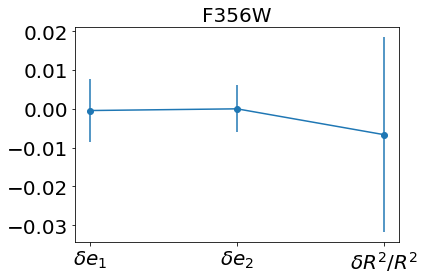

In [26]:
Fts=20
oshape=np.loadtxt(stamp_dirs+slicename+"_cooshape.cat");print(stamp_dirs+slicename+"_cooshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_comshape.cat")
wwshape=np.loadtxt(stamp_dirs+slicename+"_cowshape.cat")
indx=np.where(oshape[:,5]>80)
deshape=[]
for index in indx[0]:
    deshape.append([oshape[index][0]-wshape[index][0],oshape[index][1]-wshape[index][1],(oshape[index][2]-wshape[index][2])/oshape[index][2]])
deshape=np.array(deshape);print(deshape.shape)
dwshape=[]
for index in indx[0]:
    dwshape.append([oshape[index][0]-wwshape[index][0],oshape[index][1]-wwshape[index][1],(oshape[index][2]-wwshape[index][2])/oshape[index][2]])
dwshape=np.array(dwshape);print(dwshape.shape)
print(np.mean(deshape[:,0]),np.std(deshape[:,0]))
print(np.mean(deshape[:,1]),np.std(deshape[:,1]))
print(np.mean(deshape[:,2]),np.median(deshape[:,2]),np.std(deshape[:,2]))
plt.errorbar([1,2,3],[np.mean(deshape[:,0]),np.mean(deshape[:,1]),np.mean(deshape[:,2])],
             yerr=[np.std(deshape[:,0]),np.std(deshape[:,1]),np.std(deshape[:,2])],marker='o')
#plt.errorbar([1,2,3],[np.mean(dwshape[:,0]),np.mean(dwshape[:,1]),np.mean(dwshape[:,2])],
#             yerr=[np.std(dwshape[:,0]),np.std(dwshape[:,1]),np.std(dwshape[:,2])],marker='o')
plt.xticks([1,2,3],['$\delta{e_1}$','$\delta{e_2}$','$\delta{R^2}/R^2$'],fontsize=Fts)
plt.yticks(fontsize=Fts)
#plt.legend(fontsize=Fts,loc='upper left')
plt.title(filte,fontsize=Fts)
plt.tight_layout()
plt.savefig("/home/lnie/code/JWST/co356W.pdf")

/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it1_UPDC_rev4_cooshape.cat
(23, 3)
(23, 3)
-0.0014848078814708302 0.006005808741635086
0.0013990278041810648 0.004489108249335839
-0.0034118316236670413 0.0018094463888400983 0.011667367304310169


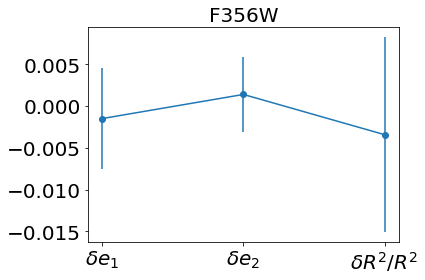

In [9]:
slicename="F356Walong_it1_UPDC_rev4"
Fts=20;print(stamp_dirs+slicename+"_cooshape.cat")
oshape=np.loadtxt(stamp_dirs+slicename+"_3mcoshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_3mcmshape.cat")
wwshape=np.loadtxt(stamp_dirs+slicename+"_3mcwshape.cat")
indx=np.where(oshape[:,5]>100)
deshape=[]
for index in indx[0]:
    deshape.append([oshape[index][0]-wshape[index][0],oshape[index][1]-wshape[index][1],(oshape[index][2]-wshape[index][2])/oshape[index][2]])
deshape=np.array(deshape);print(deshape.shape)
dwshape=[]
for index in indx[0]:
    dwshape.append([oshape[index][0]-wwshape[index][0],oshape[index][1]-wwshape[index][1],(oshape[index][2]-wwshape[index][2])/oshape[index][2]])
dwshape=np.array(dwshape);print(dwshape.shape)
print(np.mean(deshape[:,0]),np.std(deshape[:,0]))
print(np.mean(deshape[:,1]),np.std(deshape[:,1]))
print(np.mean(deshape[:,2]),np.median(deshape[:,2]),np.std(deshape[:,2]))
plt.errorbar([1,2,3],[np.mean(deshape[:,0]),np.mean(deshape[:,1]),np.mean(deshape[:,2])],
             yerr=[np.std(deshape[:,0]),np.std(deshape[:,1]),np.std(deshape[:,2])],marker='o')
#plt.errorbar([1,2,3],[np.mean(dwshape[:,0]),np.mean(dwshape[:,1]),np.mean(dwshape[:,2])],
#             yerr=[np.std(dwshape[:,0]),np.std(dwshape[:,1]),np.std(dwshape[:,2])],marker='o')
plt.xticks([1,2,3],['$\delta{e_1}$','$\delta{e_2}$','$\delta{R^2}/R^2$'],fontsize=Fts)
plt.yticks(fontsize=Fts)
#plt.legend(fontsize=Fts,loc='upper left')
plt.title(filte,fontsize=Fts)
plt.tight_layout()
plt.savefig("/home/lnie/code/JWST/co356W.pdf")

(23, 3)
(23, 3)
7.680460948165329e-05 0.007284724889298749
4.6936262114181875e-06 0.005474069866761806
-0.0019592586881891543 -0.0018239006834151273 0.02198436377806147


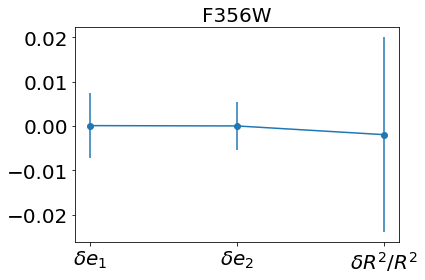

In [8]:
import numpy as np
import matplotlib.pyplot as plt
fn="/data/JWST_rev/coadd_img/rev4/parallel_field/F356Walong_it1_UPDC_rev4.fits"
catname="/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star/F356Walong_it0_UPDC_rev4_star.cat"
stampname="/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it0_UPDC_rev4_star.fits"
maskname="/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it0_UPDC_rev4_mask.fits"
Cam="NIRCam/"
filte="F356W"
odirs="/data/SMACS0723_NIRCam_pipeline1.8.1/"+filte+'/'
dirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'
PCdirs="/home/lnie/data/PC/JWST/"+Cam+filte+'/'
stamp_dirs=dirs+"/catalogue/star_stamps/"
tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")]  
Fts=20
oshape=np.loadtxt(stamp_dirs+slicename+"_cooshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_comshape.cat")
wwshape=np.loadtxt(stamp_dirs+slicename+"_cowshape.cat")
indx=np.where(oshape[:,5]>100)
deshape=[]
for index in indx[0]:
    deshape.append([oshape[index][0]-wshape[index][0],oshape[index][1]-wshape[index][1],(oshape[index][2]-wshape[index][2])/oshape[index][2]])
deshape=np.array(deshape);print(deshape.shape)
dwshape=[]
for index in indx[0]:
    dwshape.append([oshape[index][0]-wwshape[index][0],oshape[index][1]-wwshape[index][1],(oshape[index][2]-wwshape[index][2])/oshape[index][2]])
dwshape=np.array(dwshape);print(dwshape.shape)
print(np.mean(deshape[:,0]),np.std(deshape[:,0]))
print(np.mean(deshape[:,1]),np.std(deshape[:,1]))
print(np.mean(deshape[:,2]),np.median(deshape[:,2]),np.std(deshape[:,2]))
plt.errorbar([1,2,3],[np.mean(deshape[:,0]),np.mean(deshape[:,1]),np.mean(deshape[:,2])],
             yerr=[np.std(deshape[:,0]),np.std(deshape[:,1]),np.std(deshape[:,2])],marker='o')
'''plt.errorbar([1,2,3],[np.mean(dwshape[:,0]),np.mean(dwshape[:,1]),np.mean(dwshape[:,2])],
             yerr=[np.std(dwshape[:,0]),np.std(dwshape[:,1]),np.std(dwshape[:,2])],marker='o')'''
plt.xticks([1,2,3],['$\delta{e_1}$','$\delta{e_2}$','$\delta{R^2}/R^2$'],fontsize=Fts)
plt.yticks(fontsize=Fts)
#plt.legend(fontsize=Fts,loc='upper left')
plt.title(filte,fontsize=Fts)
plt.tight_layout()
#plt.savefig("/home/lnie/code/JWST/co277W.pdf")

In [13]:
ls /home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it0_UPDC_rev4_cooshape.cat

/bin/bash: /home/lnie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ls: 无法访问 '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it0_UPDC_rev4_cooshape.cat': 没有那个文件或目录


In [16]:
ls ls /home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356*

/bin/bash: /home/lnie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ls: 无法访问 'ls': 没有那个文件或目录
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it0_UPDC_rev4_mask.fits
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it0_UPDC_rev4_star.fits
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it1_UPDC_rev4_3mcmshape.cat
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it1_UPDC_rev4_3mcoshape.cat
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it1_UPDC_rev4_3mcwshape.cat
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it1_UPDC_rev4_comixchi.fits
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it1_UPDC_rev4_comixresidu.fits
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_it1_UPDC_rev4_comodel.fits
/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/F356Walong_i